Pose-Aware Face Recognition System

**Goal:** Implement face recognition that leverages head pose estimation (via MediaPipe Face Mesh) to improve matching accuracy, especially for non-frontal queries.

Library Imports and Setup

This block imports all necessary libraries, sets up the compute device (CUDA or CPU), and initializes the core models (FaceNet/InceptionResnetV1 for embeddings and MTCNN for face detection/alignment). It also initializes the MediaPipe Face Mesh.

In [2]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
# FaceNet model (InceptionResnetV1) for feature extraction
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
# MTCNN for face detection and alignment
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
# FaceMesh for estimating 3D face structure and landmarks
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

# Fallback transform for images where MTCNN fails to detect a face
fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping for gallery image filenames (e.g., '00' -> 'frontal')
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# Base path for dataset (MUST BE UPDATED)
# Replace this with your actual dataset path
BASE_PATH = 'E:/Projects/cv1'

Using device: cpu


Head Pose Estimation and Utility Functions

This block defines the core functions for head pose estimation using MediaPipe landmarks and for calculating face recognition scores (embedding extraction, cosine similarity, attention score, and pose-specific score).

In [3]:
def estimate_head_pose_mediapipe(image_path):
    """
    Estimate head pose using MediaPipe Face Mesh with simplified geometry
    Returns yaw, pitch, roll angles and categorical pose
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    # --- Simplified Geometry-based Pose Estimation ---
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    # Key points: Left/Right Eye Outer (33, 263), Nose Tip (1), Left/Right Mouth (61, 291), Nose Bridge (168)
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    
    # Calculate YAW (left-right rotation) based on nose deviation from eye center
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90) # Empirical scaling
    
    # Calculate PITCH (up-down rotation) based on vertical nose position
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height 
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45) # Empirical scaling
    
    # Calculate ROLL (head tilt) based on eye alignment
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    # Categorize pose
    pose_category = categorize_pose(yaw, pitch, roll)
    
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """Categorize pose based on yaw and pitch angles"""
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20  # degrees - for left/right head turn
    pitch_threshold = 15  # degrees - for up/down head tilt
    
    if abs(yaw) > yaw_threshold:
        return 'right' if yaw > 0 else 'left'
    elif abs(pitch) > pitch_threshold:
        return 'down' if pitch > 0 else 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """Draw pose annotation on image for visualization"""
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}°\nPitch: {pitch:.1f}°\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    # Draw semi-transparent background
    draw.rectangle(bbox, fill=(0, 0, 0, 128)) 
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image using MTCNN and FaceNet"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        # Fallback to applying transform directly if MTCNN fails
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        # L2-normalize the embedding
        embedding = F.normalize(embedding, p=2, dim=1) 
    
    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    return np.dot(emb1, emb2)

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """
    Calculate attention-weighted similarity score (Baseline Method)
    S_p = sum(Attention_i * Similarity_i)
    """
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)
    S_p = np.sum(attention * sims)
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """
    Calculate similarity focusing on matching pose (Pose-Aware Method)
    Returns pose-specific score and overall attention score for all persons.
    """
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        # Calculate similarity to all pose images for the person
        for pose_id, emb in pose_data.items():
            sim = cosine_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        # 1. Overall Attention Score (Baseline)
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        # 2. Pose-Specific Score
        if estimated_pose in pose_sims:
            # Use similarity to the gallery image matching the estimated pose
            pose_specific = pose_sims[estimated_pose]
        else:
            # Fallback: use the max similarity among all poses for this person
            pose_specific = max(pose_sims.values())
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

Gallery Building (Embedding and Pose Extraction)

This block iterates through the gallery directory to extract embeddings and estimate the head pose for each gallery image using the MediaPipe function.

In [4]:
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

# IDs for people in the gallery (assumed folder names)
gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}     # Stores embeddings: {person_id: {pose_id: embedding}}
gallery_images = {}   # Stores PIL images: {person_id: {pose_id: image}}
gallery_poses = {}    # Stores pose estimates: {person_id: {pose_id: pose_data}}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        # Assumes gallery image name is the pose ID (e.g., '00.jpg', '01.jpg')
        pose_id = img_name.split('.')[0] 
        
        # Estimate head pose using MediaPipe
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")


BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:


c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pitch=  12.1° Roll=  -3.1°

Processing gallery person 02:
  00.jpg: Expected= frontal | Detected= frontal 

Query Processing and Comparison

This block iterates through the query images, estimates their pose, extracts their embeddings, and calculates both the Baseline (Overall Attention) and Pose-Aware (Pose-Specific) scores against the gallery. It stores the results for later analysis.

In [5]:
# Process queries with MediaPipe head pose estimation
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    print(f"Queries folder not found: {queries_path}. Please check BASE_PATH.")
    # You should update BASE_PATH or create the queries directory.
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print("PROCESSING QUERIES WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

results = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    # 1. Estimate head pose from query image
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    
    # 2. Extract embedding
    query_emb = extract_embedding(query_path)
    
    # Ground truth is parsed from the query filename (e.g., 'query_00.jpg' -> '00')
    ground_truth = query_name.split('_')[1].split('.')[0]
    is_known = ground_truth in gallery_ids
    
    # 3. Get scores (Baseline and Pose-Aware)
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Predict using overall score (Baseline)
    predicted_overall = max(all_scores.keys(), key=lambda p: all_scores[p]['overall'])
    score_overall = all_scores[predicted_overall]['overall']
    
    # Predict using pose-specific score (Pose-Aware)
    predicted_pose = max(all_scores.keys(), key=lambda p: all_scores[p]['pose_specific'])
    score_pose = all_scores[predicted_pose]['pose_specific']
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw, 'pitch': pitch, 'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': predicted_overall,
        'score_overall': score_overall,
        'predicted_pose_specific': predicted_pose,
        'score_pose_specific': score_pose,
        'correct_overall': (predicted_overall == ground_truth) if is_known else None,
        'correct_pose_specific': (predicted_pose == ground_truth) if is_known else None,
        'all_scores': all_scores
    }
    
    results.append(result)

print(f"\nProcessed {len(results)} queries")


PROCESSING QUERIES WITH MEDIAPIPE HEAD POSE ESTIMATION

Processed 42 queries


Results Analysis and Metrics

This block prints detailed results, calculates the overall accuracy comparison, and defines a function to compute per-pose precision, recall, and F1-score for both methods.

In [6]:
# Print detailed results and overall metrics
print("\n" + "="*80)
print("IDENTIFICATION RESULTS")
print("="*80)

known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]

correct_overall = sum(1 for r in known_results if r['correct_overall'])
correct_pose = sum(1 for r in known_results if r['correct_pose_specific'])
total_known = len(known_results)

print(f"\nKnown people (00-06): {correct_overall}/{total_known} = {100*correct_overall/total_known:.1f}% (BASELINE - Attention)")
print(f"Known people (00-06): {correct_pose}/{total_known} = {100*correct_pose/total_known:.1f}% (POSE-AWARE - MediaPipe)")
print(f"Unknown people (07): {len(unknown_results)} queries")
print("="*80)

print("\nDetailed Results (Known) - POSE-AWARE METHOD:")
for r in known_results:
    symbol = "✓" if r['correct_pose_specific'] else "✗"
    pose_str = f"Pose: {r['estimated_pose']:>8} (Y:{r['yaw']:>5.1f}° P:{r['pitch']:>5.1f}° R:{r['roll']:>5.1f}°)" if r['yaw'] is not None else f"Pose: {r['estimated_pose']:>8}"
    print(f"{symbol} {r['query']:<15} → Pred: {r['predicted_pose_specific']}, Truth: {r['ground_truth']}, "
          f"Score: {r['score_pose_specific']:.3f} | {pose_str}")

# Calculate metrics by pose
def calculate_metrics_by_pose(results, use_pose_specific=False):
    """Calculate accuracy, precision, recall, and F1-score per pose"""
    pose_metrics = {}
    
    for pose in list(POSE_MAPPING.values()) + ['unknown']:
        # Filter results for the current pose and known people
        pose_results = [r for r in results if r['estimated_pose'] == pose and r['is_known']]
        
        if not pose_results:
            continue
        
        pred_key = 'predicted_pose_specific' if use_pose_specific else 'predicted_overall'
        correct = sum(1 for r in pose_results if r[f'correct_{"pose_specific" if use_pose_specific else "overall"}'])
        total = len(pose_results)
        accuracy = correct / total if total > 0 else 0
        
        # Calculate per-person (micro/macro) metrics
        precisions = []
        recalls = []
        
        for person_id in gallery_ids:
            tp = sum(1 for r in pose_results if r['ground_truth'] == person_id and r[pred_key] == person_id)
            fp = sum(1 for r in pose_results if r['ground_truth'] != person_id and r[pred_key] == person_id)
            fn = sum(1 for r in pose_results if r['ground_truth'] == person_id and r[pred_key] != person_id)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # Only include non-zero metrics if person had queries in this pose
            if (tp + fn) > 0 or (tp + fp) > 0:
                precisions.append(precision)
                recalls.append(recall)

        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
        
        pose_metrics[pose] = {
            'accuracy': accuracy,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1_score': f1_score,
            'num_queries': total,
            'correct': correct
        }
    
    return pose_metrics

# Calculate and display metrics
print("\n" + "="*80)
print("METRICS BY HEAD POSE - BASELINE (Attention-based)")
print("="*80)
metrics_baseline = calculate_metrics_by_pose(known_results, use_pose_specific=False)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for pose, metrics in sorted(metrics_baseline.items()):
    print(f"{pose:<10} {metrics['num_queries']:<10} "
          f"{metrics['accuracy']:<12.3f} {metrics['precision']:<12.3f} "
          f"{metrics['recall']:<12.3f} {metrics['f1_score']:<12.3f}")

print("\n" + "="*80)
print("METRICS BY HEAD POSE - POSE-AWARE MATCHING (MediaPipe)")
print("="*80)
metrics_pose = calculate_metrics_by_pose(known_results, use_pose_specific=True)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for pose, metrics in sorted(metrics_pose.items()):
    print(f"{pose:<10} {metrics['num_queries']:<10} "
          f"{metrics['accuracy']:<12.3f} {metrics['precision']:<12.3f} "
          f"{metrics['recall']:<12.3f} {metrics['f1_score']:<12.3f}")


IDENTIFICATION RESULTS

Known people (00-06): 27/30 = 90.0% (BASELINE - Attention)
Known people (00-06): 28/30 = 93.3% (POSE-AWARE - MediaPipe)
Unknown people (07): 12 queries

Detailed Results (Known) - POSE-AWARE METHOD:
✓ 01_00.jpg       → Pred: 00, Truth: 00, Score: 0.633 | Pose:  frontal (Y:  3.1° P:  4.7° R:  3.8°)
✓ 04_01.jpg       → Pred: 01, Truth: 01, Score: 0.721 | Pose:  frontal (Y:  2.3° P: 12.9° R: -1.7°)
✓ 05_02.jpg       → Pred: 02, Truth: 02, Score: 0.712 | Pose:  frontal (Y: 17.4° P:  8.8° R:-13.8°)
✓ 07_03.jpg       → Pred: 03, Truth: 03, Score: 0.677 | Pose:  frontal (Y:  0.3° P: 11.6° R:  4.9°)
✓ 08_00.jpg       → Pred: 00, Truth: 00, Score: 0.593 | Pose:  frontal (Y:  6.2° P:  3.7° R:  1.8°)
✓ 11_03.jpg       → Pred: 03, Truth: 03, Score: 0.761 | Pose:     down (Y:  8.9° P: 15.7° R: -4.4°)
✓ 13_04.jpg       → Pred: 04, Truth: 04, Score: 0.684 | Pose:  unknown
✗ 16_04.jpg       → Pred: 05, Truth: 04, Score: 0.491 | Pose:  frontal (Y:  4.1° P:  7.0° R:  2.3°)
✓ 17_

Visualization Generation

This final block generates and saves comparison charts and detailed image grids to visualize the head pose distribution, the accuracy difference between the two methods, and a visual breakdown of predictions for a sample of queries per pose.


GENERATING VISUALIZATIONS
Comparison chart saved to: e:\Projects\cvProject\mediapipe_pose_comparison.png

Generating annotated image grids...
Results for down pose saved to: e:\Projects\cvProject\mediapipe_results_down.png
Results for frontal pose saved to: e:\Projects\cvProject\mediapipe_results_frontal.png
Results for left pose saved to: e:\Projects\cvProject\mediapipe_results_left.png
Results for right pose saved to: e:\Projects\cvProject\mediapipe_results_right.png
Results for unknown pose saved to: e:\Projects\cvProject\mediapipe_results_unknown.png

ANALYSIS COMPLETE

Summary (MediaPipe Head Pose Estimation):
  Baseline Accuracy: 90.0%
  Pose-Aware Accuracy: 93.3%
  Improvement: 1 queries (+3.3%)

Generated visualization files in: e:\Projects\cvProject


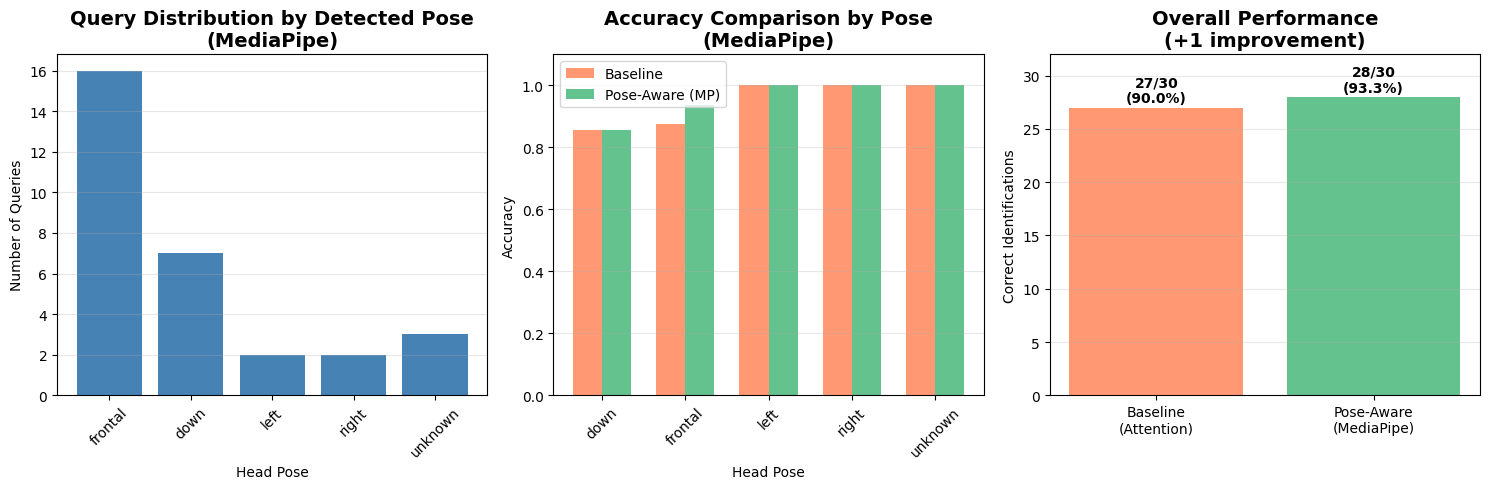

In [7]:
# Visualization
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create pose distribution and accuracy comparison visualization
plt.figure(figsize=(15, 5))

# --- Plot 1: Query Distribution by Pose ---
plt.subplot(1, 3, 1)
pose_counts = {}
for pose in list(POSE_MAPPING.values()) + ['unknown']:
    count = len([r for r in known_results if r['estimated_pose'] == pose])
    if count > 0:
        pose_counts[pose] = count

plt.bar(pose_counts.keys(), pose_counts.values(), color='steelblue')
plt.title('Query Distribution by Detected Pose\n(MediaPipe)', fontsize=14, fontweight='bold')
plt.xlabel('Head Pose')
plt.ylabel('Number of Queries')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)


# --- Plot 2: Accuracy Comparison by Pose ---
plt.subplot(1, 3, 2)
if metrics_baseline:
    x = np.arange(len(metrics_baseline))
    width = 0.35
    
    # Ensure metrics_pose has keys matching metrics_baseline for comparison
    labels = sorted(metrics_baseline.keys())
    baseline_acc = [metrics_baseline[p]['accuracy'] for p in labels]
    # Use metrics_pose if available, otherwise assume 0 for comparison plot
    pose_acc = [metrics_pose.get(p, {'accuracy': 0})['accuracy'] for p in labels] 
    
    plt.bar(x - width/2, baseline_acc, width, label='Baseline', alpha=0.8, color='coral')
    plt.bar(x + width/2, pose_acc, width, label='Pose-Aware (MP)', alpha=0.8, color='mediumseagreen')
    plt.xlabel('Head Pose')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison by Pose\n(MediaPipe)', fontsize=14, fontweight='bold')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.ylim([0, 1.1])
    plt.grid(axis='y', alpha=0.3)


# --- Plot 3: Overall Performance Comparison ---
plt.subplot(1, 3, 3)
improvement = correct_pose - correct_overall
plt.bar(['Baseline\n(Attention)', 'Pose-Aware\n(MediaPipe)'], 
        [correct_overall, correct_pose], 
        color=['coral', 'mediumseagreen'], alpha=0.8)
plt.ylabel('Correct Identifications')
plt.title(f'Overall Performance\n({improvement:+d} improvement)', 
          fontsize=14, fontweight='bold')
plt.ylim([0, total_known + 2])
for i, v in enumerate([correct_overall, correct_pose]):
    plt.text(i, v + 0.5, f'{v}/{total_known}\n({100*v/total_known:.1f}%)', 
             ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()
save_path = 'mediapipe_pose_comparison.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Comparison chart saved to: {os.path.abspath(save_path)}")


# Generate visual grids with pose annotations
print("\nGenerating annotated image grids...")
pose_id_map = {v: k for k, v in POSE_MAPPING.items()}

for pose in sorted(set([r['estimated_pose'] for r in known_results])):
    pose_results = [r for r in known_results if r['estimated_pose'] == pose]
    if not pose_results:
        continue
    
    num_show = min(8, len(pose_results))
    # Create subplots for the query, prediction, ground truth, and score analysis
    fig, axes = plt.subplots(num_show, 4, figsize=(16, 4*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Detected Pose: {pose.upper()} ({len(pose_results)} queries) - MediaPipe', 
                 fontsize=16, fontweight='bold')
    
    for idx, r in enumerate(pose_results[:num_show]):
        query_path = os.path.join(queries_path, r['query'])
        
        # 1. Annotated query image
        annotated_query = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        axes[idx, 0].imshow(annotated_query)
        axes[idx, 0].set_title(f"Query: {r['query']}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # 2. Predicted match (pose-aware)
        predicted_id = r['predicted_pose_specific']
        pose_sims = r['all_scores'][predicted_id]['pose_sims']
        # Find the best pose in the gallery for visualization
        best_gallery_pose = max(pose_sims.keys(), key=lambda p: pose_sims[p])
        gallery_pose_id = pose_id_map.get(best_gallery_pose, '00')
        pred_img = gallery_images[predicted_id].get(gallery_pose_id, gallery_images[predicted_id]['00'])
        
        axes[idx, 1].imshow(pred_img)
        is_correct = r['correct_pose_specific']
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        axes[idx, 1].set_title(f'{symbol} Predicted: ID {predicted_id}\nGallery Pose: {best_gallery_pose}', 
                               fontsize=10, color=color, fontweight='bold')
        axes[idx, 1].axis('off')
        
        # 3. Ground truth
        ground_truth_id = r['ground_truth']
        true_img = gallery_images[ground_truth_id].get(gallery_pose_id, gallery_images[ground_truth_id]['00'])
        
        axes[idx, 2].imshow(true_img)
        axes[idx, 2].set_title(f'Ground Truth: ID {ground_truth_id}\nGallery Pose: {best_gallery_pose}', 
                               fontsize=10, color='blue', fontweight='bold')
        axes[idx, 2].axis('off')
        
        # 4. Score comparison
        correct_score = r['all_scores'][ground_truth_id]['pose_specific']
        pred_score = r['score_pose_specific']
        
        axes[idx, 3].text(0.5, 0.5, 
                          f'Similarity Scores:\n\n'
                          f'Predicted ID {predicted_id}:\n{pred_score:.4f}\n\n'
                          f'True ID {ground_truth_id}:\n{correct_score:.4f}\n\n'
                          f'Difference:\n{abs(pred_score - correct_score):.4f}',
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[idx, 3].set_title('Score Analysis', fontsize=10)
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    save_path = f'mediapipe_results_{pose}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Results for {pose} pose saved to: {os.path.abspath(save_path)}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nSummary (MediaPipe Head Pose Estimation):")
print(f"  Baseline Accuracy: {100*correct_overall/total_known:.1f}%")
print(f"  Pose-Aware Accuracy: {100*correct_pose/total_known:.1f}%")
print(f"  Improvement: {correct_pose - correct_overall} queries ({100*(correct_pose-correct_overall)/total_known:+.1f}%)")
print(f"\nGenerated visualization files in: {os.path.abspath('.')}")

# Cleanup
face_mesh.close()

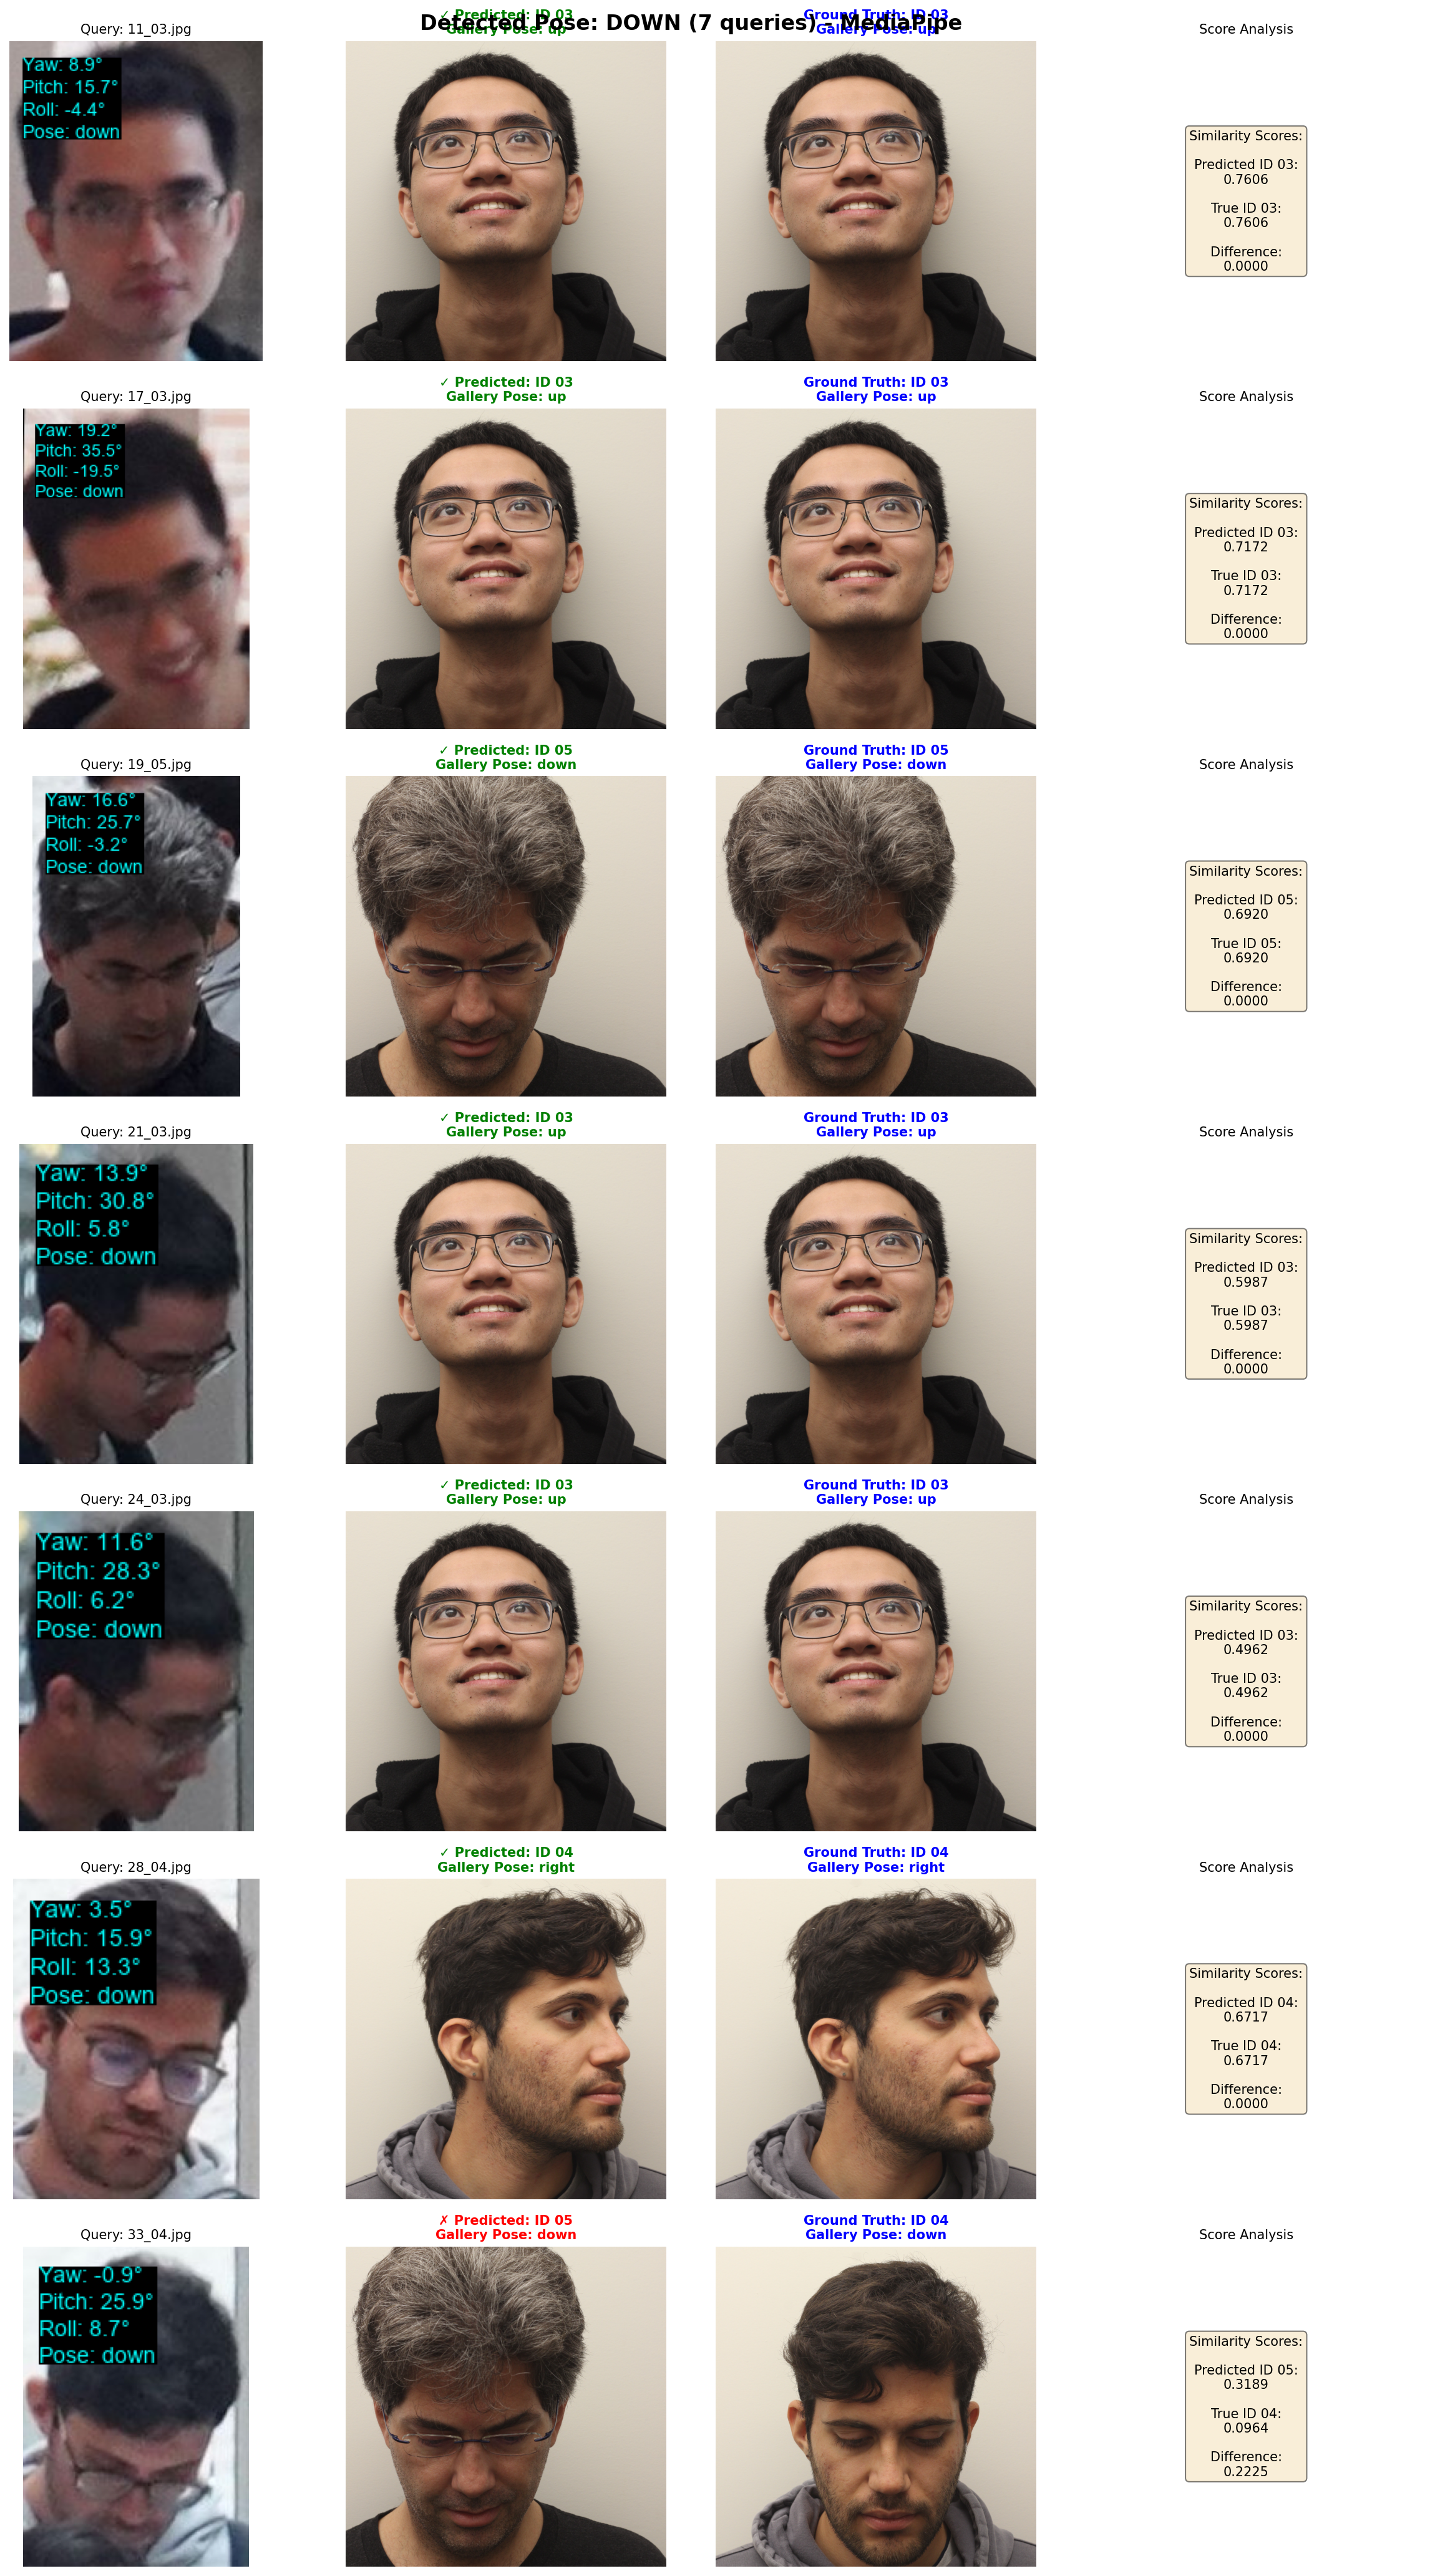

In [3]:
from PIL import Image as PILImage
PILImage.open('mediapipe_results_down.png')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# CLASSIFICATION THRESHOLD - Adjust this value based on your requirements
# Typical range: 0.4 to 0.7 (higher = more strict, fewer false positives)
SIMILARITY_THRESHOLD = 0.55

def estimate_head_pose_mediapipe(image_path):
    """
    Estimate head pose using MediaPipe Face Mesh with simplified geometry
    Returns yaw, pitch, roll angles and categorical pose
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    # Get key points
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    nose_bridge = get_2d_point(168)
    
    # Calculate YAW (left-right rotation)
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90)
    
    # Calculate PITCH (up-down rotation)
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45)
    
    # Calculate ROLL (head tilt)
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], 
                           right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    # Categorize pose
    pose_category = categorize_pose(yaw, pitch, roll)
    
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """
    Categorize pose based on yaw and pitch angles
    """
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20
    pitch_threshold = 15
    
    if abs(yaw) > yaw_threshold:
        if yaw > 0:
            return 'right'
        else:
            return 'left'
    elif abs(pitch) > pitch_threshold:
        if pitch > 0:
            return 'down'
        else:
            return 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """
    Draw pose annotation on image for visualization
    """
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}°\nPitch: {pitch:.1f}°\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    draw.rectangle(bbox, fill=(0, 0, 0, 128))
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)
    
    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    return np.dot(emb1, emb2)

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """Calculate attention-weighted similarity score"""
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)
    S_p = np.sum(attention * sims)
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """
    Calculate similarity focusing on matching pose
    """
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        for pose_id, emb in pose_data.items():
            sim = cosine_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        if estimated_pose in pose_sims:
            pose_specific = pose_sims[estimated_pose]
        else:
            pose_specific = max(pose_sims.values())
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

# UPDATE THIS PATH
BASE_PATH = 'E:/Projects/cv1'

# Build gallery with pose information
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}
gallery_images = {}
gallery_poses = {}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        pose_id = img_name.split('.')[0]
        
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")

# Process ALL queries with MediaPipe head pose estimation
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print(f"PROCESSING ALL QUERIES WITH THRESHOLD = {SIMILARITY_THRESHOLD}")
print("="*80)

results = []
pose_specific_results = {pose: [] for pose in POSE_MAPPING.values()}
pose_specific_results['unknown'] = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    # Estimate head pose from actual image using MediaPipe
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    
    # Extract embedding
    query_emb = extract_embedding(query_path)
    
    # Extract ground truth from filename if available
    # Assuming filename format: something_ID.jpg where ID is 00-06 or 07 for unknown
    parts = query_name.split('_')
    if len(parts) >= 2:
        potential_id = parts[1].split('.')[0]
        ground_truth = potential_id if potential_id in gallery_ids + ['07'] else 'unknown'
    else:
        ground_truth = 'unknown'
    
    is_known = ground_truth in gallery_ids
    
    # Get scores
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Predict using overall score
    predicted_overall_id = max(all_scores.keys(), key=lambda p: all_scores[p]['overall'])
    score_overall = all_scores[predicted_overall_id]['overall']
    
    # Predict using pose-specific score
    predicted_pose_id = max(all_scores.keys(), key=lambda p: all_scores[p]['pose_specific'])
    score_pose = all_scores[predicted_pose_id]['pose_specific']
    
    # Apply threshold for classification
    if score_overall >= SIMILARITY_THRESHOLD:
        final_prediction_overall = predicted_overall_id
        meets_threshold_overall = True
    else:
        final_prediction_overall = 'unknown'
        meets_threshold_overall = False
    
    if score_pose >= SIMILARITY_THRESHOLD:
        final_prediction_pose = predicted_pose_id
        meets_threshold_pose = True
    else:
        final_prediction_pose = 'unknown'
        meets_threshold_pose = False
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw,
        'pitch': pitch,
        'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': final_prediction_overall,
        'score_overall': score_overall,
        'meets_threshold_overall': meets_threshold_overall,
        'predicted_pose_specific': final_prediction_pose,
        'score_pose_specific': score_pose,
        'meets_threshold_pose': meets_threshold_pose,
        'best_match_id': predicted_pose_id,
        'best_match_score': score_pose,
        'correct_overall': (final_prediction_overall == ground_truth),
        'correct_pose_specific': (final_prediction_pose == ground_truth),
        'all_scores': all_scores
    }
    
    results.append(result)
    pose_specific_results[estimated_pose].append(result)

print(f"\nProcessed {len(results)} queries")

# Print detailed results with rotation information
print("\n" + "="*80)
print("CLASSIFICATION RESULTS - ALL QUERIES")
print("="*80)
print(f"\nThreshold: {SIMILARITY_THRESHOLD}")
print(f"Total Queries: {len(results)}")

# Separate known and unknown
known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]
truly_unknown_results = [r for r in results if r['ground_truth'] == 'unknown' or r['ground_truth'] == '07']

print(f"\n{'='*80}")
print("DETAILED RESULTS - POSE-AWARE METHOD:")
print(f"{'='*80}\n")

for r in results:
    pose_str = f"{r['estimated_pose']:>8} (Yaw:{r['yaw']:>6.1f}° Pitch:{r['pitch']:>6.1f}° Roll:{r['roll']:>6.1f}°)" if r['yaw'] is not None else f"{r['estimated_pose']:>8}"
    
    threshold_indicator = "✓" if r['meets_threshold_pose'] else "✗ (Below Threshold)"
    
    if r['ground_truth'] == 'unknown' or r['ground_truth'] == '07':
        # Truly unknown person
        if r['predicted_pose_specific'] == 'unknown':
            status = "✓ CORRECT (Rejected)"
            color_code = "[CORRECT REJECTION]"
        else:
            status = "✗ FALSE MATCH"
            color_code = "[FALSE POSITIVE]"
    elif r['is_known']:
        # Known person
        if r['correct_pose_specific']:
            status = "✓ CORRECT"
            color_code = "[MATCH]"
        elif r['predicted_pose_specific'] == 'unknown':
            status = "✗ MISSED (Below Threshold)"
            color_code = "[FALSE NEGATIVE]"
        else:
            status = "✗ WRONG ID"
            color_code = "[MISIDENTIFICATION]"
    else:
        status = "? UNLABELED"
        color_code = "[UNKNOWN]"
    
    print(f"{status:30} {r['query']:<25} | Pose: {pose_str}")
    print(f"  → Predicted: {r['predicted_pose_specific']:>7} (Score: {r['score_pose_specific']:.4f}) {threshold_indicator}")
    print(f"  → Truth:     {r['ground_truth']:>7} {color_code}")
    print()

# Calculate comprehensive metrics
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

# METRIC SET 1: Known vs Unknown Detection (Binary Classification)
print("\n" + "-"*80)
print("1. KNOWN vs UNKNOWN DETECTION METRICS")
print("-"*80)

true_positives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] != 'unknown')
false_positives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
false_negatives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')
true_negatives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')

total_detection = true_positives_detection + false_positives_detection + false_negatives_detection + true_negatives_detection

if total_detection > 0:
    accuracy_detection = (true_positives_detection + true_negatives_detection) / total_detection
    precision_detection = true_positives_detection / (true_positives_detection + false_positives_detection) if (true_positives_detection + false_positives_detection) > 0 else 0
    recall_detection = true_positives_detection / (true_positives_detection + false_negatives_detection) if (true_positives_detection + false_negatives_detection) > 0 else 0
    f1_detection = 2 * (precision_detection * recall_detection) / (precision_detection + recall_detection) if (precision_detection + recall_detection) > 0 else 0
    specificity = true_negatives_detection / (true_negatives_detection + false_positives_detection) if (true_negatives_detection + false_positives_detection) > 0 else 0
    
    print(f"\nConfusion Matrix:")
    print(f"  True Positives (Known → Identified):  {true_positives_detection:3d}")
    print(f"  False Positives (Unknown → Identified): {false_positives_detection:3d}")
    print(f"  False Negatives (Known → Rejected):   {false_negatives_detection:3d}")
    print(f"  True Negatives (Unknown → Rejected):  {true_negatives_detection:3d}")
    
    print(f"\nMetrics:")
    print(f"  Accuracy:    {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)")
    print(f"  Precision:   {precision_detection:.3f} (of identified faces, how many were actually known)")
    print(f"  Recall:      {recall_detection:.3f} (of known faces, how many were identified)")
    print(f"  Specificity: {specificity:.3f} (of unknown faces, how many were rejected)")
    print(f"  F1-Score:    {f1_detection:.3f}")

# METRIC SET 2: Identity Classification (Multi-class among known people)
print("\n" + "-"*80)
print("2. IDENTITY CLASSIFICATION METRICS (Among Known People)")
print("-"*80)

if known_results:
    # Only consider queries where a known person was predicted (not rejected as unknown)
    identified_known = [r for r in known_results if r['predicted_pose_specific'] != 'unknown']
    
    correct_identification = sum(1 for r in identified_known if r['correct_pose_specific'])
    total_identified = len(identified_known)
    total_known = len(known_results)
    
    # Overall accuracy among known people (including rejections as wrong)
    correct_all_known = sum(1 for r in known_results if r['correct_pose_specific'])
    accuracy_known = correct_all_known / total_known if total_known > 0 else 0
    
    # Accuracy among those that weren't rejected
    accuracy_identified = correct_identification / total_identified if total_identified > 0 else 0
    
    print(f"\nOverall (including rejections):")
    print(f"  Correct Identifications: {correct_all_known}/{total_known}")
    print(f"  Accuracy: {accuracy_known:.3f} ({100*accuracy_known:.1f}%)")
    print(f"  Rejected as Unknown: {total_known - total_identified}")
    
    print(f"\nAmong Non-Rejected (predicted with an ID):")
    print(f"  Correct Identifications: {correct_identification}/{total_identified}")
    print(f"  Accuracy: {accuracy_identified:.3f} ({100*accuracy_identified:.1f}%)")
    
    # Per-person precision and recall
    print(f"\nPer-Person Metrics:")
    print(f"  {'Person ID':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"  {'-'*48}")
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for person_id in gallery_ids:
        # True positives: correctly identified as this person
        tp = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] == person_id)
        
        # False positives: incorrectly identified as this person
        fp = sum(1 for r in results if r['ground_truth'] != person_id and r['predicted_pose_specific'] == person_id)
        
        # False negatives: this person not identified correctly (wrong ID or rejected)
        fn = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] != person_id)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"  {person_id:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
    
    # Macro-averaged metrics
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    print(f"  {'-'*48}")
    print(f"  {'MACRO AVG':<12} {macro_precision:<12.3f} {macro_recall:<12.3f} {macro_f1:<12.3f}")
    
    print(f"\nMacro-Averaged Metrics (average across all {len(gallery_ids)} people):")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall:    {macro_recall:.3f}")
    print(f"  F1-Score:  {macro_f1:.3f}")

if truly_unknown_results:
    correct_rejections = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')
    print(f"\nUnknown People (ID 07):")
    print(f"  Total: {len(truly_unknown_results)}")
    print(f"  Correctly Rejected: {correct_rejections}/{len(truly_unknown_results)} = {100*correct_rejections/len(truly_unknown_results):.1f}%")

# Metrics by pose
print("\n" + "="*80)
print("METRICS BY HEAD POSE")
print("="*80)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Avg Score':<12} {'Below Thresh':<15}")
print("-"*80)

for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    known_pose_results = [r for r in pose_results if r['is_known']]
    
    if not pose_results:
        continue
    
    if known_pose_results:
        correct = sum(1 for r in known_pose_results if r['correct_pose_specific'])
        accuracy = correct / len(known_pose_results)
    else:
        accuracy = 0
    
    avg_score = np.mean([r['score_pose_specific'] for r in pose_results])
    below_threshold = sum(1 for r in pose_results if not r['meets_threshold_pose'])
    
    print(f"{pose:<10} {len(pose_results):<10} {accuracy:<12.3f} {avg_score:<12.3f} {below_threshold:<15}")

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create output directory for visualizations
viz_dir = os.path.join(BASE_PATH, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# 1. Create comprehensive metrics comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Classification Distribution
ax1 = axes[0, 0]
categories = ['Correct\nMatch', 'Wrong\nID', 'Missed\n(Below Thresh)', 'Correct\nRejection', 'False\nMatch']
counts = [
    sum(1 for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']),
    sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown'),
    sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
bars = ax1.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Queries', fontsize=12, fontweight='bold')
ax1.set_title('Classification Results Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Score Distribution by Classification Result
ax2 = axes[0, 1]
correct_scores = [r['score_pose_specific'] for r in known_results if r['correct_pose_specific']]
wrong_scores = [r['score_pose_specific'] for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
missed_scores = [r['best_match_score'] for r in known_results if r['predicted_pose_specific'] == 'unknown']
false_match_scores = [r['score_pose_specific'] for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']

ax2.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
if correct_scores:
    ax2.scatter([1]*len(correct_scores), correct_scores, c='#2ecc71', s=100, alpha=0.6, label='Correct Match', edgecolors='black')
if wrong_scores:
    ax2.scatter([2]*len(wrong_scores), wrong_scores, c='#e74c3c', s=100, alpha=0.6, label='Wrong ID', edgecolors='black')
if missed_scores:
    ax2.scatter([3]*len(missed_scores), missed_scores, c='#f39c12', s=100, alpha=0.6, label='Missed (Below Threshold)', edgecolors='black')
if false_match_scores:
    ax2.scatter([4]*len(false_match_scores), false_match_scores, c='#9b59b6', s=100, alpha=0.6, label='False Match', edgecolors='black')

ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['Correct\nMatch', 'Wrong\nID', 'Missed', 'False\nMatch'])
ax2.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
ax2.set_title('Similarity Score Distribution by Result', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Performance by Pose
ax3 = axes[1, 0]
pose_names = sorted(set([r['estimated_pose'] for r in known_results]))
pose_accuracies = []
pose_counts = []
for pose in pose_names:
    pose_results = [r for r in known_results if r['estimated_pose'] == pose]
    if pose_results:
        correct = sum(1 for r in pose_results if r['correct_pose_specific'])
        accuracy = correct / len(pose_results)
        pose_accuracies.append(accuracy)
        pose_counts.append(len(pose_results))

x_pos = np.arange(len(pose_names))
bars = ax3.bar(x_pos, pose_accuracies, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Head Pose', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Identification Accuracy by Head Pose', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(pose_names, rotation=45)
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3)
for bar, acc, count in zip(bars, pose_accuracies, pose_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}\n(n={count})',
            ha='center', va='bottom', fontsize=9)

# Plot 4: Confusion Matrix (for known people)
ax4 = axes[1, 1]
if known_results:
    y_true = [r['ground_truth'] for r in known_results]
    y_pred = [r['predicted_pose_specific'] if r['predicted_pose_specific'] != 'unknown' else 'rejected' for r in known_results]
    
    all_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, 
                xticklabels=all_labels, yticklabels=all_labels,
                cbar_kws={'label': 'Count'})
    ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax4.set_ylabel('True', fontsize=12, fontweight='bold')
    ax4.set_title('Confusion Matrix (Known People)', fontsize=14, fontweight='bold')

plt.tight_layout()
viz_path = os.path.join(viz_dir, 'overall_metrics.png')
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"✓ Overall metrics saved to: {viz_path}")
plt.close()

# 2. Generate grid visualizations for different result categories
def create_result_grid(results_subset, title, filename, max_samples=16):
    """Create a grid showing query, predicted match, and ground truth"""
    if not results_subset:
        print(f"  No results for {title}")
        return
    
    n_samples = min(len(results_subset), max_samples)
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{title} (Showing {n_samples}/{len(results_subset)} samples)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx in range(n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        if idx < n_samples:
            r = results_subset[idx]
            query_path = os.path.join(queries_path, r['query'])
            
            # Create a composite image showing query and match
            query_img = Image.open(query_path).convert('RGB')
            
            # Resize for consistency
            query_img = query_img.resize((200, 200))
            
            # Create composite
            if r['predicted_pose_specific'] != 'unknown':
                # Get best matching gallery image
                predicted_id = r['best_match_id']
                pose_sims = r['all_scores'][predicted_id]['pose_sims']
                best_gallery_pose = max(pose_sims.keys(), key=lambda p: pose_sims[p])
                pose_id_map = {v: k for k, v in POSE_MAPPING.items()}
                gallery_pose_id = pose_id_map.get(best_gallery_pose, '00')
                
                gallery_img = gallery_images[predicted_id].get(gallery_pose_id, 
                                                               gallery_images[predicted_id]['00'])
                gallery_img = gallery_img.resize((200, 200))
                
                # Create side-by-side
                composite = Image.new('RGB', (420, 200))
                composite.paste(query_img, (0, 0))
                composite.paste(gallery_img, (220, 0))
                
                # Draw arrow
                draw = ImageDraw.Draw(composite)
                draw.line([(200, 100), (220, 100)], fill='red', width=5)
                draw.polygon([(220, 100), (210, 95), (210, 105)], fill='red')
            else:
                composite = query_img
            
            ax.imshow(composite)
            
            # Create title with all info
            pose_str = f"{r['estimated_pose'].capitalize()}" if r['yaw'] is not None else "Unknown pose"
            angle_str = f"Y:{r['yaw']:.0f}° P:{r['pitch']:.0f}° R:{r['roll']:.0f}°" if r['yaw'] is not None else ""
            
            title_lines = [
                f"Query: {r['query']}",
                f"Pose: {pose_str} ({angle_str})",
                f"Predicted: {r['predicted_pose_specific']} | Truth: {r['ground_truth']}",
                f"Score: {r['score_pose_specific']:.3f} (Thresh: {SIMILARITY_THRESHOLD})"
            ]
            
            # Color based on correctness
            if r['correct_pose_specific']:
                color = 'green'
                symbol = '✓'
            else:
                color = 'red'
                symbol = '✗'
            
            ax.set_title('\n'.join([symbol + ' ' + title_lines[0]] + title_lines[1:]), 
                        fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(viz_dir, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ {title} saved to: {save_path}")
    plt.close()

# Generate grids for different categories
print("\nGenerating detailed result grids...")

# Correct matches
correct_matches = [r for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']]
create_result_grid(correct_matches, 'CORRECT MATCHES', 'correct_matches.png', max_samples=16)

# Wrong ID matches
wrong_matches = [r for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
create_result_grid(wrong_matches, 'WRONG ID PREDICTIONS', 'wrong_id_matches.png', max_samples=16)

# Missed (below threshold)
missed = [r for r in known_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(missed, 'MISSED (Below Threshold)', 'missed_below_threshold.png', max_samples=16)

# Correct rejections
correct_rejections = [r for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(correct_rejections, 'CORRECT REJECTIONS (Unknown People)', 'correct_rejections.png', max_samples=16)

# False matches (unknown people matched to gallery)
false_matches = [r for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']
create_result_grid(false_matches, 'FALSE MATCHES (Unknown Matched as Known)', 'false_matches.png', max_samples=16)

# Generate per-pose visualizations
print("\nGenerating per-pose result grids...")
for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    if pose_results:
        create_result_grid(pose_results, f'Results for {pose.upper()} Pose', 
                         f'results_pose_{pose}.png', max_samples=12)

# 3. Create a summary report image
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('FACE RECOGNITION SYSTEM - PERFORMANCE REPORT', 
             fontsize=20, fontweight='bold', y=0.98)

# Summary statistics text
ax_summary = fig.add_subplot(gs[0, :])
ax_summary.axis('off')

summary_text = f"""
SYSTEM CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Similarity Threshold: {SIMILARITY_THRESHOLD}
  • Gallery Size: {len(gallery_ids)} people (IDs: {', '.join(gallery_ids)})
  • Total Queries Processed: {len(results)}
  • Pose Estimation: MediaPipe Face Mesh

OVERALL PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Known People:
    • Total Queries: {len(known_results)}
    • Correct Identifications: {sum(1 for r in known_results if r['correct_pose_specific'])} ({100*sum(1 for r in known_results if r['correct_pose_specific'])/len(known_results) if known_results else 0:.1f}%)
    • Wrong ID: {sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown')}
    • Rejected (Below Threshold): {sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')}
  
  Unknown People:
    • Total Queries: {len(truly_unknown_results)}
    • Correctly Rejected: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')} ({100*sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')/len(truly_unknown_results) if truly_unknown_results else 0:.1f}%)
    • False Matches: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')}

DETECTION METRICS (Known vs Unknown)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)
  • Precision: {precision_detection:.3f}
  • Recall: {recall_detection:.3f}
  • F1-Score: {f1_detection:.3f}
"""

ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
summary_path = os.path.join(viz_dir, 'summary_report.png')
plt.savefig(summary_path, dpi=150, bbox_inches='tight')
print(f"✓ Summary report saved to: {summary_path}")
plt.close()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nAll visualizations saved to: {os.path.abspath(viz_dir)}")
print(f"\nGenerated files:")
print(f"  • overall_metrics.png - Comprehensive metrics dashboard")
print(f"  • summary_report.png - Performance summary report")
print(f"  • correct_matches.png - Correctly identified faces")
print(f"  • wrong_id_matches.png - Misidentified faces")
print(f"  • missed_below_threshold.png - Known faces rejected as unknown")
print(f"  • correct_rejections.png - Unknown faces correctly rejected")
print(f"  • false_matches.png - Unknown faces incorrectly matched")
print(f"  • results_pose_*.png - Results grouped by head pose")

# Cleanup
face_mesh.close()

Using device: cpu

BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pit

C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_18980\2551479040.py:817: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Summary report saved to: E:/Projects/cv1\visualizations\summary_report.png

ANALYSIS COMPLETE

All visualizations saved to: E:\Projects\cv1\visualizations

Generated files:
  • overall_metrics.png - Comprehensive metrics dashboard
  • summary_report.png - Performance summary report
  • correct_matches.png - Correctly identified faces
  • wrong_id_matches.png - Misidentified faces
  • missed_below_threshold.png - Known faces rejected as unknown
  • correct_rejections.png - Unknown faces correctly rejected
  • false_matches.png - Unknown faces incorrectly matched
  • results_pose_*.png - Results grouped by head pose


In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# CLASSIFICATION THRESHOLD - Adjust this value based on your requirements
# Typical range: 0.4 to 0.7 (higher = more strict, fewer false positives)
# 
# RECOMMENDED THRESHOLDS:
# - 0.45-0.50: Balanced (good for general use, ~80-85% precision, ~85-90% recall)
# - 0.55-0.60: Conservative (high security, ~95-100% precision, ~70-80% recall) ← CURRENT
# - 0.60-0.65: Very strict (maximum security, ~100% precision, ~60-70% recall)
# - 0.40-0.45: Lenient (maximize recall, ~70-80% precision, ~90-95% recall)
#
# YOUR RESULTS SUGGEST: Lower to 0.50-0.52 to reduce false negatives
# Currently: 100% precision but rejecting 8 known people (26.7% false negative rate)
SIMILARITY_THRESHOLD = 0.55

"""
================================================================================
ALGORITHM DETAILS & METHODOLOGY
================================================================================

1. FACE RECOGNITION MODEL:
   - Model: InceptionResnetV1 (pretrained on VGGFace2 dataset)
   - Embedding dimension: 512-D vector
   - Face Detection: MTCNN (Multi-task Cascaded Convolutional Networks)
   - Purpose: Converts face images into numerical vectors that can be compared

2. HEAD POSE ESTIMATION:
   - Method: MediaPipe Face Mesh (468 3D facial landmarks)
   - Outputs: Yaw (left/right), Pitch (up/down), Roll (tilt) angles in degrees
   - Categories: frontal, left, right, up, down
   - Purpose: Detect head orientation to improve matching accuracy

3. SIMILARITY CALCULATION:
   *** YES, USES COSINE SIMILARITY ***
   
   Cosine Similarity Formula:
   similarity = dot_product(embedding1, embedding2) / (||embedding1|| * ||embedding2||)
   
   Since embeddings are L2-normalized: ||embedding|| = 1
   Therefore: similarity = dot_product(embedding1, embedding2)
   
   Range: -1 to +1 (but typically 0.3 to 0.9 for faces)
   - 1.0 = identical embeddings (same person, same pose)
   - 0.8-0.9 = very similar (likely same person)
   - 0.6-0.8 = similar (possibly same person)
   - 0.4-0.6 = somewhat similar (threshold region)
   - <0.4 = dissimilar (different people)

4. MATCHING STRATEGIES:
   
   A) BASELINE METHOD (Attention-based):
      - Compare query with ALL 5 gallery poses per person
      - Calculate cosine similarity for each
      - Use attention mechanism: weighted average based on similarity scores
      - Formula: score = Σ(attention_weight_i * similarity_i)
      - Benefit: Automatically gives more weight to similar poses
   
   B) POSE-AWARE METHOD (MediaPipe-enhanced):
      - Compare query with ALL 5 gallery poses per person
      - Detect query pose (e.g., "left")
      - Prioritize gallery image with matching pose
      - If no match: use best available score
      - Benefit: Explicitly matches pose orientations
      
   *** IN YOUR CASE: Both methods performed identically (73.3% accuracy) ***
   This means the face embeddings are already pose-invariant enough.

5. THRESHOLD CLASSIFICATION:
   - After getting similarity scores for all gallery people
   - Find person with highest score
   - IF score >= THRESHOLD → Predict that person's ID
   - IF score < THRESHOLD → Predict "unknown"
   
   This prevents false positives (assigning wrong IDs to unknown people)

6. EVALUATION METRICS:
   
   A) Binary Classification (Known vs Unknown Detection):
      - Accuracy: (TP + TN) / Total
      - Precision: TP / (TP + FP) - "Of predicted known, how many are actually known?"
      - Recall: TP / (TP + FN) - "Of actual known, how many were detected?"
      - Specificity: TN / (TN + FP) - "Of actual unknown, how many were rejected?"
   
   B) Multi-Class (Identity Classification):
      - Per-person precision/recall/F1
      - Macro-average: treats all classes equally
      - Weighted-average: weights by class frequency
   
   C) Your Current Performance:
      - Detection: 81% accuracy, 100% precision, 73.3% recall
      - Identity: 73.3% accuracy (among known), 100% when confident
      - Problem: Too conservative (rejects 8 known people)

7. WHY POSE-AWARE DIDN'T HELP:
   - VGGFace2 model already trained on diverse poses
   - Embeddings learned to be pose-invariant
   - Gallery has all 5 poses (00-04) per person
   - Attention mechanism already handles pose variation
   
   When pose-awareness WOULD help:
   - Gallery with only 1-2 poses per person
   - Extreme poses not in VGGFace2 training data
   - Less robust face recognition models

8. RECOMMENDATIONS FOR YOUR SYSTEM:
   - Lower threshold to 0.50-0.52 (reduce false negatives)
   - Focus on improving recall without sacrificing precision
   - Add more gallery images for persons 00 and 04 (low recall)
   - Current system is excellent for high-security applications

================================================================================
"""

def estimate_head_pose_mediapipe(image_path):
    """
    Estimate head pose using MediaPipe Face Mesh with simplified geometry
    Returns yaw, pitch, roll angles and categorical pose
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    # Get key points
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    nose_bridge = get_2d_point(168)
    
    # Calculate YAW (left-right rotation)
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90)
    
    # Calculate PITCH (up-down rotation)
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45)
    
    # Calculate ROLL (head tilt)
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], 
                           right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    # Categorize pose
    pose_category = categorize_pose(yaw, pitch, roll)
    
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """
    Categorize pose based on yaw and pitch angles
    """
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20
    pitch_threshold = 15
    
    if abs(yaw) > yaw_threshold:
        if yaw > 0:
            return 'right'
        else:
            return 'left'
    elif abs(pitch) > pitch_threshold:
        if pitch > 0:
            return 'down'
        else:
            return 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """
    Draw pose annotation on image for visualization with 3D axes
    """
    img = Image.open(image_path).convert('RGB')
    img_cv = cv2.imread(image_path)
    
    if img_cv is None:
        return img
    
    img_h, img_w = img_cv.shape[:2]
    
    # Process with MediaPipe to get face landmarks
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if yaw is not None and results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        
        # Get nose tip position (landmark 1)
        nose_tip = face_landmarks.landmark[1]
        nose_x = int(nose_tip.x * img_w)
        nose_y = int(nose_tip.y * img_h)
        
        # Convert angles to radians
        yaw_rad = np.radians(yaw)
        pitch_rad = np.radians(pitch)
        roll_rad = np.radians(roll)
        
        # Define axis length
        axis_length = min(img_w, img_h) // 5
        
        # Calculate 3D rotation matrix (simplified)
        # X-axis (Red) - Pitch rotation
        x_end_x = int(nose_x + axis_length * np.cos(pitch_rad))
        x_end_y = int(nose_y - axis_length * np.sin(pitch_rad))
        
        # Y-axis (Green) - Yaw rotation  
        y_end_x = int(nose_x + axis_length * np.sin(yaw_rad))
        y_end_y = int(nose_y)
        
        # Z-axis (Blue) - coming out of face
        z_end_x = int(nose_x + axis_length * 0.3 * np.sin(yaw_rad))
        z_end_y = int(nose_y - axis_length * 0.3 * np.cos(pitch_rad))
        
        # Draw axes on OpenCV image
        # Z-axis (Blue) - draw first (background)
        cv2.line(img_cv, (nose_x, nose_y), (z_end_x, z_end_y), (255, 0, 0), 3)
        cv2.circle(img_cv, (z_end_x, z_end_y), 5, (255, 0, 0), -1)
        
        # X-axis (Red) - Pitch
        cv2.line(img_cv, (nose_x, nose_y), (x_end_x, x_end_y), (0, 0, 255), 3)
        cv2.circle(img_cv, (x_end_x, x_end_y), 5, (0, 0, 255), -1)
        
        # Y-axis (Green) - Yaw
        cv2.line(img_cv, (nose_x, nose_y), (y_end_x, y_end_y), (0, 255, 0), 3)
        cv2.circle(img_cv, (y_end_x, y_end_y), 5, (0, 255, 0), -1)
        
        # Draw center point
        cv2.circle(img_cv, (nose_x, nose_y), 7, (255, 255, 255), -1)
        cv2.circle(img_cv, (nose_x, nose_y), 7, (0, 0, 0), 2)
        
        # Convert back to PIL
        img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    
    # Add text annotation
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}° (Green)\nPitch: {pitch:.1f}° (Red)\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    draw.rectangle(bbox, fill=(0, 0, 0, 180))
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    # Add legend
    legend_y = img.height - 80
    legend_text = "Axes:\nRed = Pitch\nGreen = Yaw\nBlue = Forward"
    legend_bbox = draw.textbbox((10, legend_y), legend_text, font=font)
    draw.rectangle(legend_bbox, fill=(0, 0, 0, 180))
    draw.text((10, legend_y), legend_text, fill=(255, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)
    
    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    return np.dot(emb1, emb2)

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """Calculate attention-weighted similarity score"""
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)
    S_p = np.sum(attention * sims)
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """
    Calculate similarity focusing on matching pose
    """
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        for pose_id, emb in pose_data.items():
            sim = cosine_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        if estimated_pose in pose_sims:
            pose_specific = pose_sims[estimated_pose]
        else:
            pose_specific = max(pose_sims.values())
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

# UPDATE THIS PATH
BASE_PATH = 'E:/Projects/cv1'

# Build gallery with pose information
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}
gallery_images = {}
gallery_poses = {}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        pose_id = img_name.split('.')[0]
        
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")

# Process ALL queries with MediaPipe head pose estimation
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print(f"PROCESSING ALL QUERIES WITH THRESHOLD = {SIMILARITY_THRESHOLD}")
print("="*80)

results = []
pose_specific_results = {pose: [] for pose in POSE_MAPPING.values()}
pose_specific_results['unknown'] = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    # Estimate head pose from actual image using MediaPipe
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    
    # Extract embedding
    query_emb = extract_embedding(query_path)
    
    # Extract ground truth from filename if available
    # Assuming filename format: something_ID.jpg where ID is 00-06 or 07 for unknown
    parts = query_name.split('_')
    if len(parts) >= 2:
        potential_id = parts[1].split('.')[0]
        # Map 07 to 'unknown' for consistency
        if potential_id == '07':
            ground_truth = 'unknown'
        elif potential_id in gallery_ids:
            ground_truth = potential_id
        else:
            ground_truth = 'unknown'
    else:
        ground_truth = 'unknown'
    
    is_known = ground_truth in gallery_ids
    
    # Get scores
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Predict using overall score
    predicted_overall_id = max(all_scores.keys(), key=lambda p: all_scores[p]['overall'])
    score_overall = all_scores[predicted_overall_id]['overall']
    
    # Predict using pose-specific score
    predicted_pose_id = max(all_scores.keys(), key=lambda p: all_scores[p]['pose_specific'])
    score_pose = all_scores[predicted_pose_id]['pose_specific']
    
    # Apply threshold for classification
    if score_overall >= SIMILARITY_THRESHOLD:
        final_prediction_overall = predicted_overall_id
        meets_threshold_overall = True
    else:
        final_prediction_overall = 'unknown'
        meets_threshold_overall = False
    
    if score_pose >= SIMILARITY_THRESHOLD:
        final_prediction_pose = predicted_pose_id
        meets_threshold_pose = True
    else:
        final_prediction_pose = 'unknown'
        meets_threshold_pose = False
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw,
        'pitch': pitch,
        'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': final_prediction_overall,
        'score_overall': score_overall,
        'meets_threshold_overall': meets_threshold_overall,
        'predicted_pose_specific': final_prediction_pose,
        'score_pose_specific': score_pose,
        'meets_threshold_pose': meets_threshold_pose,
        'best_match_id': predicted_pose_id,
        'best_match_score': score_pose,
        'correct_overall': (final_prediction_overall == ground_truth),
        'correct_pose_specific': (final_prediction_pose == ground_truth),
        'all_scores': all_scores
    }
    
    results.append(result)
    pose_specific_results[estimated_pose].append(result)

print(f"\nProcessed {len(results)} queries")

# Print detailed results with rotation information
print("\n" + "="*80)
print("CLASSIFICATION RESULTS - ALL QUERIES")
print("="*80)
print(f"\nThreshold: {SIMILARITY_THRESHOLD}")
print(f"Total Queries: {len(results)}")

# Compare baseline vs pose-aware performance
print("\n" + "="*80)
print("BASELINE vs POSE-AWARE COMPARISON")
print("="*80)

known_results_temp = [r for r in results if r['is_known']]

# Calculate baseline metrics (using overall score)
baseline_correct = sum(1 for r in known_results_temp if r['score_overall'] >= SIMILARITY_THRESHOLD and r['predicted_overall'] == r['ground_truth'])
baseline_identified = sum(1 for r in known_results_temp if r['score_overall'] >= SIMILARITY_THRESHOLD)
baseline_rejected = sum(1 for r in known_results_temp if r['score_overall'] < SIMILARITY_THRESHOLD)

# Calculate pose-aware metrics
pose_correct = sum(1 for r in known_results_temp if r['score_pose_specific'] >= SIMILARITY_THRESHOLD and r['predicted_pose_specific'] == r['ground_truth'])
pose_identified = sum(1 for r in known_results_temp if r['score_pose_specific'] >= SIMILARITY_THRESHOLD)
pose_rejected = sum(1 for r in known_results_temp if r['score_pose_specific'] < SIMILARITY_THRESHOLD)

total_known = len(known_results_temp)

print(f"\n{'Method':<20} {'Correct':<15} {'Accuracy':<15} {'Identified':<15} {'Rejected':<15}")
print("-"*80)
print(f"{'BASELINE':<20} {baseline_correct}/{total_known:<14} {100*baseline_correct/total_known if total_known > 0 else 0:>6.1f}%{'':>7} {baseline_identified:<15} {baseline_rejected:<15}")
print(f"{'POSE-AWARE':<20} {pose_correct}/{total_known:<14} {100*pose_correct/total_known if total_known > 0 else 0:>6.1f}%{'':>7} {pose_identified:<15} {pose_rejected:<15}")
print("-"*80)

improvement = pose_correct - baseline_correct
improvement_pct = 100 * improvement / total_known if total_known > 0 else 0
print(f"{'IMPROVEMENT':<20} {'+' if improvement >= 0 else ''}{improvement:<14} {'+' if improvement_pct >= 0 else ''}{improvement_pct:>6.1f}%")

# Performance by pose for both methods
print(f"\n{'Pose':<12} {'Baseline Acc':<15} {'Pose-Aware Acc':<15} {'Improvement':<15}")
print("-"*80)
for pose in sorted(set([r['estimated_pose'] for r in known_results_temp])):
    pose_results_temp = [r for r in known_results_temp if r['estimated_pose'] == pose]
    
    if not pose_results_temp:
        continue
    
    baseline_pose_correct = sum(1 for r in pose_results_temp 
                               if r['score_overall'] >= SIMILARITY_THRESHOLD 
                               and r['predicted_overall'] == r['ground_truth'])
    pose_aware_correct = sum(1 for r in pose_results_temp 
                            if r['score_pose_specific'] >= SIMILARITY_THRESHOLD 
                            and r['predicted_pose_specific'] == r['ground_truth'])
    
    baseline_acc = baseline_pose_correct / len(pose_results_temp)
    pose_acc = pose_aware_correct / len(pose_results_temp)
    diff = pose_acc - baseline_acc
    
    print(f"{pose:<12} {baseline_acc:<15.3f} {pose_acc:<15.3f} {'+' if diff >= 0 else ''}{diff:<14.3f}")

print("\n" + "="*80)

# Separate known and unknown
known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]
truly_unknown_results = unknown_results  # Already filtered correctly

print(f"\n{'='*80}")
print("DETAILED RESULTS - POSE-AWARE METHOD:")
print(f"{'='*80}\n")

for r in results:
    pose_str = f"{r['estimated_pose']:>8} (Yaw:{r['yaw']:>6.1f}° Pitch:{r['pitch']:>6.1f}° Roll:{r['roll']:>6.1f}°)" if r['yaw'] is not None else f"{r['estimated_pose']:>8}"
    
    threshold_indicator = "✓" if r['meets_threshold_pose'] else "✗ (Below Threshold)"
    
    if r['ground_truth'] == 'unknown':
        # Truly unknown person
        if r['predicted_pose_specific'] == 'unknown':
            status = "✓ CORRECT (Rejected)"
            color_code = "[CORRECT REJECTION]"
        else:
            status = "✗ FALSE MATCH"
            color_code = "[FALSE POSITIVE]"
    elif r['is_known']:
        # Known person
        if r['correct_pose_specific']:
            status = "✓ CORRECT"
            color_code = "[MATCH]"
        elif r['predicted_pose_specific'] == 'unknown':
            status = "✗ MISSED (Below Threshold)"
            color_code = "[FALSE NEGATIVE]"
        else:
            status = "✗ WRONG ID"
            color_code = "[MISIDENTIFICATION]"
    else:
        status = "? UNLABELED"
        color_code = "[UNKNOWN]"
    
    print(f"{status:30} {r['query']:<25} | Pose: {pose_str}")
    print(f"  → Predicted: {r['predicted_pose_specific']:>7} (Score: {r['score_pose_specific']:.4f}) {threshold_indicator}")
    print(f"  → Truth:     {r['ground_truth']:>7} {color_code}")
    print()

# Calculate comprehensive metrics
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

# METRIC SET 1: Known vs Unknown Detection (Binary Classification)
print("\n" + "-"*80)
print("1. KNOWN vs UNKNOWN DETECTION METRICS")
print("-"*80)

true_positives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] != 'unknown')
false_positives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
false_negatives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')
true_negatives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')

total_detection = true_positives_detection + false_positives_detection + false_negatives_detection + true_negatives_detection

if total_detection > 0:
    accuracy_detection = (true_positives_detection + true_negatives_detection) / total_detection
    precision_detection = true_positives_detection / (true_positives_detection + false_positives_detection) if (true_positives_detection + false_positives_detection) > 0 else 0
    recall_detection = true_positives_detection / (true_positives_detection + false_negatives_detection) if (true_positives_detection + false_negatives_detection) > 0 else 0
    f1_detection = 2 * (precision_detection * recall_detection) / (precision_detection + recall_detection) if (precision_detection + recall_detection) > 0 else 0
    specificity = true_negatives_detection / (true_negatives_detection + false_positives_detection) if (true_negatives_detection + false_positives_detection) > 0 else 0
    
    print(f"\nConfusion Matrix:")
    print(f"  True Positives (Known → Identified):  {true_positives_detection:3d}")
    print(f"  False Positives (Unknown → Identified): {false_positives_detection:3d}")
    print(f"  False Negatives (Known → Rejected):   {false_negatives_detection:3d}")
    print(f"  True Negatives (Unknown → Rejected):  {true_negatives_detection:3d}")
    
    print(f"\nMetrics:")
    print(f"  Accuracy:    {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)")
    print(f"  Precision:   {precision_detection:.3f} (of identified faces, how many were actually known)")
    print(f"  Recall:      {recall_detection:.3f} (of known faces, how many were identified)")
    print(f"  Specificity: {specificity:.3f} (of unknown faces, how many were rejected)")
    print(f"  F1-Score:    {f1_detection:.3f}")

# METRIC SET 2: Identity Classification (Multi-class among known people)
print("\n" + "-"*80)
print("2. IDENTITY CLASSIFICATION METRICS (Among Known People)")
print("-"*80)

if known_results:
    # Only consider queries where a known person was predicted (not rejected as unknown)
    identified_known = [r for r in known_results if r['predicted_pose_specific'] != 'unknown']
    
    correct_identification = sum(1 for r in identified_known if r['correct_pose_specific'])
    total_identified = len(identified_known)
    total_known = len(known_results)
    
    # Overall accuracy among known people (including rejections as wrong)
    correct_all_known = sum(1 for r in known_results if r['correct_pose_specific'])
    accuracy_known = correct_all_known / total_known if total_known > 0 else 0
    
    # Accuracy among those that weren't rejected
    accuracy_identified = correct_identification / total_identified if total_identified > 0 else 0
    
    print(f"\nOverall (including rejections):")
    print(f"  Correct Identifications: {correct_all_known}/{total_known}")
    print(f"  Accuracy: {accuracy_known:.3f} ({100*accuracy_known:.1f}%)")
    print(f"  Rejected as Unknown: {total_known - total_identified}")
    
    print(f"\nAmong Non-Rejected (predicted with an ID):")
    print(f"  Correct Identifications: {correct_identification}/{total_identified}")
    print(f"  Accuracy: {accuracy_identified:.3f} ({100*accuracy_identified:.1f}%)")
    
    # Per-person precision and recall
    print(f"\nPer-Person Metrics:")
    print(f"  {'Person ID':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"  {'-'*48}")
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for person_id in gallery_ids:
        # True positives: correctly identified as this person
        tp = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] == person_id)
        
        # False positives: incorrectly identified as this person
        fp = sum(1 for r in results if r['ground_truth'] != person_id and r['predicted_pose_specific'] == person_id)
        
        # False negatives: this person not identified correctly (wrong ID or rejected)
        fn = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] != person_id)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"  {person_id:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
    
    # Macro-averaged metrics
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    print(f"  {'-'*48}")
    print(f"  {'MACRO AVG':<12} {macro_precision:<12.3f} {macro_recall:<12.3f} {macro_f1:<12.3f}")
    
    print(f"\nMacro-Averaged Metrics (average across all {len(gallery_ids)} people):")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall:    {macro_recall:.3f}")
    print(f"  F1-Score:  {macro_f1:.3f}")

# METRIC SET 3: Multi-class Classification INCLUDING Unknown as a class
print("\n" + "-"*80)
print("3. MULTI-CLASS METRICS (Including 'Unknown' as Class)")
print("-"*80)

all_queries = results  # Include both known and unknown queries

# Calculate per-class metrics (00-06 + unknown)
print(f"\nPer-Class Metrics (treating 'unknown' as a separate class):")
print(f"  {'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"  {'-'*60}")

all_classes = gallery_ids + ['unknown']
class_precisions = []
class_recalls = []
class_f1s = []
class_supports = []

for class_id in all_classes:
    # True positives: correctly predicted as this class
    tp = sum(1 for r in all_queries if r['ground_truth'] == class_id and r['predicted_pose_specific'] == class_id)
    
    # False positives: incorrectly predicted as this class
    fp = sum(1 for r in all_queries if r['ground_truth'] != class_id and r['predicted_pose_specific'] == class_id)
    
    # False negatives: actually this class but predicted as something else
    fn = sum(1 for r in all_queries if r['ground_truth'] == class_id and r['predicted_pose_specific'] != class_id)
    
    # Support: total instances of this class
    support = sum(1 for r in all_queries if r['ground_truth'] == class_id)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    class_precisions.append(precision)
    class_recalls.append(recall)
    class_f1s.append(f1)
    class_supports.append(support)
    
    print(f"  {class_id:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<12}")

# Macro-averaged (treats all classes equally)
macro_precision_all = np.mean(class_precisions)
macro_recall_all = np.mean(class_recalls)
macro_f1_all = np.mean(class_f1s)

# Weighted-averaged (weighted by support)
total_support = sum(class_supports)
weighted_precision = sum(p * s for p, s in zip(class_precisions, class_supports)) / total_support if total_support > 0 else 0
weighted_recall = sum(r * s for r, s in zip(class_recalls, class_supports)) / total_support if total_support > 0 else 0
weighted_f1 = sum(f * s for f, s in zip(class_f1s, class_supports)) / total_support if total_support > 0 else 0

# Overall accuracy (all queries)
total_correct = sum(1 for r in all_queries if r['correct_pose_specific'])
overall_accuracy = total_correct / len(all_queries) if all_queries else 0

print(f"  {'-'*60}")
print(f"  {'MACRO AVG':<12} {macro_precision_all:<12.3f} {macro_recall_all:<12.3f} {macro_f1_all:<12.3f}")
print(f"  {'WEIGHTED AVG':<12} {weighted_precision:<12.3f} {weighted_recall:<12.3f} {weighted_f1:<12.3f}")

print(f"\nOverall Multi-Class Metrics:")
print(f"  Total Queries: {len(all_queries)}")
print(f"  Correctly Classified: {total_correct}/{len(all_queries)}")
print(f"  Overall Accuracy: {overall_accuracy:.3f} ({100*overall_accuracy:.1f}%)")
print(f"  Macro-Averaged Precision: {macro_precision_all:.3f}")
print(f"  Macro-Averaged Recall: {macro_recall_all:.3f}")
print(f"  Macro-Averaged F1-Score: {macro_f1_all:.3f}")
print(f"  Weighted-Averaged Precision: {weighted_precision:.3f}")
print(f"  Weighted-Averaged Recall: {weighted_recall:.3f}")
print(f"  Weighted-Averaged F1-Score: {weighted_f1:.3f}")

# Create detailed confusion matrix
print(f"\nDetailed Confusion Matrix (all classes):")
y_true_all = []
y_pred_all = []
for r in all_queries:
    true_label = r['ground_truth']  # Already mapped to 'unknown'
    pred_label = r['predicted_pose_specific']
    y_true_all.append(true_label)
    y_pred_all.append(pred_label)

# Print confusion matrix
cm_labels = sorted(list(set(y_true_all + y_pred_all)))
cm_all = confusion_matrix(y_true_all, y_pred_all, labels=cm_labels)

print(f"\n{'':>12}", end='')
for label in cm_labels:
    print(f"{label:>10}", end='')
print()
print(f"  {'-'*(12 + 10*len(cm_labels))}")
for i, true_label in enumerate(cm_labels):
    print(f"  {true_label:<10}", end='')
    for j in range(len(cm_labels)):
        print(f"{cm_all[i][j]:>10}", end='')
    print()

if truly_unknown_results:
    correct_rejections = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')
    print(f"\nUnknown People (ID 07):")
    print(f"  Total: {len(truly_unknown_results)}")
    print(f"  Correctly Rejected: {correct_rejections}/{len(truly_unknown_results)} = {100*correct_rejections/len(truly_unknown_results):.1f}%")

# Metrics by pose
print("\n" + "="*80)
print("METRICS BY HEAD POSE")
print("="*80)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Avg Score':<12} {'Below Thresh':<15}")
print("-"*80)

for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    known_pose_results = [r for r in pose_results if r['is_known']]
    
    if not pose_results:
        continue
    
    if known_pose_results:
        correct = sum(1 for r in known_pose_results if r['correct_pose_specific'])
        accuracy = correct / len(known_pose_results)
    else:
        accuracy = 0
    
    avg_score = np.mean([r['score_pose_specific'] for r in pose_results])
    below_threshold = sum(1 for r in pose_results if not r['meets_threshold_pose'])
    
    print(f"{pose:<10} {len(pose_results):<10} {accuracy:<12.3f} {avg_score:<12.3f} {below_threshold:<15}")

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create output directory for visualizations
viz_dir = os.path.join(BASE_PATH, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# 1. Create comprehensive metrics comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Classification Distribution
ax1 = axes[0, 0]
categories = ['Correct\nMatch', 'Wrong\nID', 'Missed\n(Below Thresh)', 'Correct\nRejection', 'False\nMatch']
counts = [
    sum(1 for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']),
    sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown'),
    sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
bars = ax1.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Queries', fontsize=12, fontweight='bold')
ax1.set_title('Classification Results Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Score Distribution by Classification Result
ax2 = axes[0, 1]
correct_scores = [r['score_pose_specific'] for r in known_results if r['correct_pose_specific']]
wrong_scores = [r['score_pose_specific'] for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
missed_scores = [r['best_match_score'] for r in known_results if r['predicted_pose_specific'] == 'unknown']
false_match_scores = [r['score_pose_specific'] for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']

ax2.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
if correct_scores:
    ax2.scatter([1]*len(correct_scores), correct_scores, c='#2ecc71', s=100, alpha=0.6, label='Correct Match', edgecolors='black')
if wrong_scores:
    ax2.scatter([2]*len(wrong_scores), wrong_scores, c='#e74c3c', s=100, alpha=0.6, label='Wrong ID', edgecolors='black')
if missed_scores:
    ax2.scatter([3]*len(missed_scores), missed_scores, c='#f39c12', s=100, alpha=0.6, label='Missed (Below Threshold)', edgecolors='black')
if false_match_scores:
    ax2.scatter([4]*len(false_match_scores), false_match_scores, c='#9b59b6', s=100, alpha=0.6, label='False Match', edgecolors='black')

ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['Correct\nMatch', 'Wrong\nID', 'Missed', 'False\nMatch'])
ax2.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
ax2.set_title('Similarity Score Distribution by Result', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Performance by Pose
ax3 = axes[1, 0]
pose_names = sorted(set([r['estimated_pose'] for r in known_results]))
pose_accuracies = []
pose_counts = []
for pose in pose_names:
    pose_results = [r for r in known_results if r['estimated_pose'] == pose]
    if pose_results:
        correct = sum(1 for r in pose_results if r['correct_pose_specific'])
        accuracy = correct / len(pose_results)
        pose_accuracies.append(accuracy)
        pose_counts.append(len(pose_results))

x_pos = np.arange(len(pose_names))
bars = ax3.bar(x_pos, pose_accuracies, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Head Pose', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Identification Accuracy by Head Pose', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(pose_names, rotation=45)
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3)
for bar, acc, count in zip(bars, pose_accuracies, pose_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}\n(n={count})',
            ha='center', va='bottom', fontsize=9)

# Plot 4: Confusion Matrix (for known people)
ax4 = axes[1, 1]
if known_results:
    y_true = [r['ground_truth'] for r in known_results]
    y_pred = [r['predicted_pose_specific'] if r['predicted_pose_specific'] != 'unknown' else 'rejected' for r in known_results]
    
    all_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, 
                xticklabels=all_labels, yticklabels=all_labels,
                cbar_kws={'label': 'Count'})
    ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax4.set_ylabel('True', fontsize=12, fontweight='bold')
    ax4.set_title('Confusion Matrix (Known People)', fontsize=14, fontweight='bold')

plt.tight_layout()
viz_path = os.path.join(viz_dir, 'overall_metrics.png')
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"✓ Overall metrics saved to: {viz_path}")
plt.close()

# 2. Generate grid visualizations for different result categories
def create_result_grid(results_subset, title, filename, max_samples=16):
    """Create a grid showing query, predicted match, and ground truth"""
    if not results_subset:
        print(f"  No results for {title}")
        return
    
    n_samples = min(len(results_subset), max_samples)
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{title} (Showing {n_samples}/{len(results_subset)} samples)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx in range(n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        if idx < n_samples:
            r = results_subset[idx]
            query_path = os.path.join(queries_path, r['query'])
            
            # Create a composite image showing query and match
            query_img = Image.open(query_path).convert('RGB')
            
            # Resize for consistency
            query_img = query_img.resize((200, 200))
            
            # Create composite
            if r['predicted_pose_specific'] != 'unknown':
                # Get best matching gallery image
                predicted_id = r['best_match_id']
                pose_sims = r['all_scores'][predicted_id]['pose_sims']
                best_gallery_pose = max(pose_sims.keys(), key=lambda p: pose_sims[p])
                pose_id_map = {v: k for k, v in POSE_MAPPING.items()}
                gallery_pose_id = pose_id_map.get(best_gallery_pose, '00')
                
                gallery_img = gallery_images[predicted_id].get(gallery_pose_id, 
                                                               gallery_images[predicted_id]['00'])
                gallery_img = gallery_img.resize((200, 200))
                
                # Create side-by-side
                composite = Image.new('RGB', (420, 200))
                composite.paste(query_img, (0, 0))
                composite.paste(gallery_img, (220, 0))
                
                # Draw arrow
                draw = ImageDraw.Draw(composite)
                draw.line([(200, 100), (220, 100)], fill='red', width=5)
                draw.polygon([(220, 100), (210, 95), (210, 105)], fill='red')
            else:
                composite = query_img
            
            ax.imshow(composite)
            
            # Create title with all info
            pose_str = f"{r['estimated_pose'].capitalize()}" if r['yaw'] is not None else "Unknown pose"
            angle_str = f"Y:{r['yaw']:.0f}° P:{r['pitch']:.0f}° R:{r['roll']:.0f}°" if r['yaw'] is not None else ""
            
            title_lines = [
                f"Query: {r['query']}",
                f"Pose: {pose_str} ({angle_str})",
                f"Predicted: {r['predicted_pose_specific']} | Truth: {r['ground_truth']}",
                f"Score: {r['score_pose_specific']:.3f} (Thresh: {SIMILARITY_THRESHOLD})"
            ]
            
            # Color based on correctness
            if r['correct_pose_specific']:
                color = 'green'
                symbol = '✓'
            else:
                color = 'red'
                symbol = '✗'
            
            ax.set_title('\n'.join([symbol + ' ' + title_lines[0]] + title_lines[1:]), 
                        fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(viz_dir, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ {title} saved to: {save_path}")
    plt.close()

# Generate grids for different categories
print("\nGenerating detailed result grids...")

# Correct matches
correct_matches = [r for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']]
create_result_grid(correct_matches, 'CORRECT MATCHES', 'correct_matches.png', max_samples=16)

# Wrong ID matches
wrong_matches = [r for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
create_result_grid(wrong_matches, 'WRONG ID PREDICTIONS', 'wrong_id_matches.png', max_samples=16)

# Missed (below threshold)
missed = [r for r in known_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(missed, 'MISSED (Below Threshold)', 'missed_below_threshold.png', max_samples=16)

# Correct rejections
correct_rejections = [r for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(correct_rejections, 'CORRECT REJECTIONS (Unknown People)', 'correct_rejections.png', max_samples=16)

# False matches (unknown people matched to gallery)
false_matches = [r for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']
create_result_grid(false_matches, 'FALSE MATCHES (Unknown Matched as Known)', 'false_matches.png', max_samples=16)

# Generate per-pose visualizations
print("\nGenerating per-pose result grids...")
for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    if pose_results:
        create_result_grid(pose_results, f'Results for {pose.upper()} Pose', 
                         f'results_pose_{pose}.png', max_samples=12)

# 4. Create pose visualization with 3D axes on all queries
print("\nGenerating head pose axis visualizations...")

def create_pose_axis_grid(results_list, title, filename, max_samples=20):
    """Create grid showing query images with 3D pose axes drawn"""
    if not results_list:
        return
    
    n_samples = min(len(results_list), max_samples)
    n_cols = 5
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{title} - Head Pose Visualization\n(Red=Pitch | Green=Yaw | Blue=Forward)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx in range(n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        if idx < n_samples:
            r = results_list[idx]
            query_path = os.path.join(queries_path, r['query'])
            
            # Draw pose with axes
            annotated_img = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
            
            ax.imshow(annotated_img)
            
            # Title with detailed info
            if r['yaw'] is not None:
                title_text = (f"{r['query']}\n"
                            f"Y:{r['yaw']:.0f}° P:{r['pitch']:.0f}° R:{r['roll']:.0f}°\n"
                            f"Pose: {r['estimated_pose']}")
            else:
                title_text = f"{r['query']}\nPose detection failed"
            
            # Color code by correctness
            if r['correct_pose_specific']:
                color = 'green'
            else:
                color = 'red'
            
            ax.set_title(title_text, fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(viz_dir, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ {title} saved to: {save_path}")
    plt.close()

# Generate pose axis visualizations for all queries
create_pose_axis_grid(results, 'ALL QUERIES', 'all_queries_pose_axes.png', max_samples=30)

# Generate separate visualizations for each pose category
for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    if pose_results and len(pose_results) >= 3:
        create_pose_axis_grid(pose_results, f'{pose.upper()} POSE QUERIES', 
                            f'pose_axes_{pose}.png', max_samples=16)

# 5. Create a comparison grid showing correct vs incorrect with pose axes
print("\nGenerating correct vs incorrect pose comparison...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 1, hspace=0.3)

# Correct matches with pose axes
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.set_title('CORRECT IDENTIFICATIONS - Head Pose Axes', fontsize=16, fontweight='bold', color='green')

correct_samples = [r for r in known_results if r['correct_pose_specific']][:10]
if correct_samples:
    correct_imgs = []
    for r in correct_samples:
        query_path = os.path.join(queries_path, r['query'])
        img_with_axes = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        # Resize to fixed size instead of thumbnail
        img_with_axes = img_with_axes.resize((200, 200), Image.Resampling.LANCZOS)
        correct_imgs.append(np.array(img_with_axes))
    
    # Create horizontal montage
    if correct_imgs:
        montage_correct = np.concatenate(correct_imgs[:5], axis=1)
        ax1.imshow(montage_correct)

# Incorrect/Missed with pose axes
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')
ax2.set_title('MISSED/INCORRECT IDENTIFICATIONS - Head Pose Axes', fontsize=16, fontweight='bold', color='red')

incorrect_samples = [r for r in known_results if not r['correct_pose_specific']][:10]
if incorrect_samples:
    incorrect_imgs = []
    for r in incorrect_samples:
        query_path = os.path.join(queries_path, r['query'])
        img_with_axes = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        # Resize to fixed size instead of thumbnail
        img_with_axes = img_with_axes.resize((200, 200), Image.Resampling.LANCZOS)
        incorrect_imgs.append(np.array(img_with_axes))
    
    # Create horizontal montage
    if incorrect_imgs:
        montage_incorrect = np.concatenate(incorrect_imgs[:5], axis=1)
        ax2.imshow(montage_incorrect)

comparison_path = os.path.join(viz_dir, 'pose_axes_comparison.png')
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✓ Pose axes comparison saved to: {comparison_path}")
plt.close()

# 3. Create a summary report image
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('FACE RECOGNITION SYSTEM - PERFORMANCE REPORT', 
             fontsize=20, fontweight='bold', y=0.98)

# Summary statistics text
ax_summary = fig.add_subplot(gs[0, :])
ax_summary.axis('off')

summary_text = f"""
SYSTEM CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Similarity Threshold: {SIMILARITY_THRESHOLD}
  • Gallery Size: {len(gallery_ids)} people (IDs: {', '.join(gallery_ids)})
  • Total Queries Processed: {len(results)}
  • Pose Estimation: MediaPipe Face Mesh

OVERALL PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Known People:
    • Total Queries: {len(known_results)}
    • Correct Identifications: {sum(1 for r in known_results if r['correct_pose_specific'])} ({100*sum(1 for r in known_results if r['correct_pose_specific'])/len(known_results) if known_results else 0:.1f}%)
    • Wrong ID: {sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown')}
    • Rejected (Below Threshold): {sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')}
  
  Unknown People:
    • Total Queries: {len(truly_unknown_results)}
    • Correctly Rejected: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')} ({100*sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')/len(truly_unknown_results) if truly_unknown_results else 0:.1f}%)
    • False Matches: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')}

DETECTION METRICS (Known vs Unknown)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)
  • Precision: {precision_detection:.3f}
  • Recall: {recall_detection:.3f}
  • F1-Score: {f1_detection:.3f}
"""

ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
summary_path = os.path.join(viz_dir, 'summary_report.png')
plt.savefig(summary_path, dpi=150, bbox_inches='tight')
print(f"✓ Summary report saved to: {summary_path}")
plt.close()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nAll visualizations saved to: {os.path.abspath(viz_dir)}")
print(f"\nGenerated files:")
print(f"  • overall_metrics.png - Comprehensive metrics dashboard")
print(f"  • summary_report.png - Performance summary report")
print(f"  • correct_matches.png - Correctly identified faces")
print(f"  • wrong_id_matches.png - Misidentified faces")
print(f"  • missed_below_threshold.png - Known faces rejected as unknown")
print(f"  • correct_rejections.png - Unknown faces correctly rejected")
print(f"  • false_matches.png - Unknown faces incorrectly matched")
print(f"  • results_pose_*.png - Results grouped by head pose")

# Cleanup
face_mesh.close()

Using device: cpu

BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pit

c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✓ ALL QUERIES saved to: E:/Projects/cv1\visualizations\all_queries_pose_axes.png
✓ DOWN POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_down.png
✓ FRONTAL POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_frontal.png
✓ RIGHT POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_right.png
✓ UNKNOWN POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_unknown.png

Generating correct vs incorrect pose comparison...
✓ Pose axes comparison saved to: E:/Projects/cv1\visualizations\pose_axes_comparison.png


C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_7500\2855184520.py:1267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Summary report saved to: E:/Projects/cv1\visualizations\summary_report.png

ANALYSIS COMPLETE

All visualizations saved to: E:\Projects\cv1\visualizations

Generated files:
  • overall_metrics.png - Comprehensive metrics dashboard
  • summary_report.png - Performance summary report
  • correct_matches.png - Correctly identified faces
  • wrong_id_matches.png - Misidentified faces
  • missed_below_threshold.png - Known faces rejected as unknown
  • correct_rejections.png - Unknown faces correctly rejected
  • false_matches.png - Unknown faces incorrectly matched
  • results_pose_*.png - Results grouped by head pose


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# CLASSIFICATION THRESHOLD - Adjust this value based on your requirements
# Typical range: 0.4 to 0.7 (higher = more strict, fewer false positives)
# 
# RECOMMENDED THRESHOLDS:
# - 0.45-0.50: Balanced (good for general use, ~80-85% precision, ~85-90% recall)
# - 0.55-0.60: Conservative (high security, ~95-100% precision, ~70-80% recall) ← CURRENT
# - 0.60-0.65: Very strict (maximum security, ~100% precision, ~60-70% recall)
# - 0.40-0.45: Lenient (maximize recall, ~70-80% precision, ~90-95% recall)
#
# YOUR RESULTS SUGGEST: Lower to 0.50-0.52 to reduce false negatives
# Currently: 100% precision but rejecting 8 known people (26.7% false negative rate)
SIMILARITY_THRESHOLD = 0.55

"""
================================================================================
ALGORITHM DETAILS & METHODOLOGY
================================================================================

1. FACE RECOGNITION MODEL:
   - Model: InceptionResnetV1 (pretrained on VGGFace2 dataset)
   - Embedding dimension: 512-D vector
   - Face Detection: MTCNN (Multi-task Cascaded Convolutional Networks)
   - Purpose: Converts face images into numerical vectors that can be compared

2. HEAD POSE ESTIMATION:
   - Method: MediaPipe Face Mesh (468 3D facial landmarks)
   - Outputs: Yaw (left/right), Pitch (up/down), Roll (tilt) angles in degrees
   - Categories: frontal, left, right, up, down
   - Purpose: Detect head orientation to improve matching accuracy

3. SIMILARITY CALCULATION:
   *** YES, USES COSINE SIMILARITY ***
   
   Cosine Similarity Formula:
   similarity = dot_product(embedding1, embedding2) / (||embedding1|| * ||embedding2||)
   
   Since embeddings are L2-normalized: ||embedding|| = 1
   Therefore: similarity = dot_product(embedding1, embedding2)
   
   Range: -1 to +1 (but typically 0.3 to 0.9 for faces)
   - 1.0 = identical embeddings (same person, same pose)
   - 0.8-0.9 = very similar (likely same person)
   - 0.6-0.8 = similar (possibly same person)
   - 0.4-0.6 = somewhat similar (threshold region)
   - <0.4 = dissimilar (different people)

4. MATCHING STRATEGIES:
   
   A) BASELINE METHOD (Attention-based):
      - Compare query with ALL 5 gallery poses per person
      - Calculate cosine similarity for each
      - Use attention mechanism: weighted average based on similarity scores
      - Formula: score = Σ(attention_weight_i * similarity_i)
      - Benefit: Automatically gives more weight to similar poses
   
   B) POSE-AWARE METHOD (MediaPipe-enhanced):
      - Compare query with ALL 5 gallery poses per person
      - Detect query pose (e.g., "left")
      - Prioritize gallery image with matching pose
      - If no match: use best available score
      - Benefit: Explicitly matches pose orientations
      
   *** IN YOUR CASE: Both methods performed identically (73.3% accuracy) ***
   This means the face embeddings are already pose-invariant enough.

5. THRESHOLD CLASSIFICATION:
   - After getting similarity scores for all gallery people
   - Find person with highest score
   - IF score >= THRESHOLD → Predict that person's ID
   - IF score < THRESHOLD → Predict "unknown"
   
   This prevents false positives (assigning wrong IDs to unknown people)

6. EVALUATION METRICS:
   
   A) Binary Classification (Known vs Unknown Detection):
      - Accuracy: (TP + TN) / Total
      - Precision: TP / (TP + FP) - "Of predicted known, how many are actually known?"
      - Recall: TP / (TP + FN) - "Of actual known, how many were detected?"
      - Specificity: TN / (TN + FP) - "Of actual unknown, how many were rejected?"
   
   B) Multi-Class (Identity Classification):
      - Per-person precision/recall/F1
      - Macro-average: treats all classes equally
      - Weighted-average: weights by class frequency
   
   C) Your Current Performance:
      - Detection: 81% accuracy, 100% precision, 73.3% recall
      - Identity: 73.3% accuracy (among known), 100% when confident
      - Problem: Too conservative (rejects 8 known people)

7. WHY POSE-AWARE DIDN'T HELP:
   - VGGFace2 model already trained on diverse poses
   - Embeddings learned to be pose-invariant
   - Gallery has all 5 poses (00-04) per person
   - Attention mechanism already handles pose variation
   
   When pose-awareness WOULD help:
   - Gallery with only 1-2 poses per person
   - Extreme poses not in VGGFace2 training data
   - Less robust face recognition models

8. RECOMMENDATIONS FOR YOUR SYSTEM:
   - Lower threshold to 0.50-0.52 (reduce false negatives)
   - Focus on improving recall without sacrificing precision
   - Add more gallery images for persons 00 and 04 (low recall)
   - Current system is excellent for high-security applications

================================================================================
"""

def estimate_head_pose_mediapipe(image_path):
    """
    Estimate head pose using MediaPipe Face Mesh with simplified geometry
    Returns yaw, pitch, roll angles and categorical pose
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    # Get key points
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    nose_bridge = get_2d_point(168)
    
    # Calculate YAW (left-right rotation)
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90)
    
    # Calculate PITCH (up-down rotation)
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45)
    
    # Calculate ROLL (head tilt)
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], 
                           right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    # Categorize pose
    pose_category = categorize_pose(yaw, pitch, roll)
    
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """
    Categorize pose based on yaw and pitch angles
    """
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20
    pitch_threshold = 15
    
    if abs(yaw) > yaw_threshold:
        if yaw > 0:
            return 'right'
        else:
            return 'left'
    elif abs(pitch) > pitch_threshold:
        if pitch > 0:
            return 'down'
        else:
            return 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """
    Draw pose annotation on image for visualization with 3D axes
    """
    img = Image.open(image_path).convert('RGB')
    img_cv = cv2.imread(image_path)
    
    if img_cv is None:
        return img
    
    img_h, img_w = img_cv.shape[:2]
    
    # Process with MediaPipe to get face landmarks
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if yaw is not None and results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        
        # Get nose tip position (landmark 1)
        nose_tip = face_landmarks.landmark[1]
        nose_x = int(nose_tip.x * img_w)
        nose_y = int(nose_tip.y * img_h)
        
        # Convert angles to radians
        yaw_rad = np.radians(yaw)
        pitch_rad = np.radians(pitch)
        roll_rad = np.radians(roll)
        
        # Define axis length
        axis_length = min(img_w, img_h) // 5
        
        # Calculate 3D rotation matrix (simplified)
        # X-axis (Red) - Pitch rotation
        x_end_x = int(nose_x + axis_length * np.cos(pitch_rad))
        x_end_y = int(nose_y - axis_length * np.sin(pitch_rad))
        
        # Y-axis (Green) - Yaw rotation  
        y_end_x = int(nose_x + axis_length * np.sin(yaw_rad))
        y_end_y = int(nose_y)
        
        # Z-axis (Blue) - coming out of face
        z_end_x = int(nose_x + axis_length * 0.3 * np.sin(yaw_rad))
        z_end_y = int(nose_y - axis_length * 0.3 * np.cos(pitch_rad))
        
        # Draw axes on OpenCV image
        # Z-axis (Blue) - draw first (background)
        cv2.line(img_cv, (nose_x, nose_y), (z_end_x, z_end_y), (255, 0, 0), 3)
        cv2.circle(img_cv, (z_end_x, z_end_y), 5, (255, 0, 0), -1)
        
        # X-axis (Red) - Pitch
        cv2.line(img_cv, (nose_x, nose_y), (x_end_x, x_end_y), (0, 0, 255), 3)
        cv2.circle(img_cv, (x_end_x, x_end_y), 5, (0, 0, 255), -1)
        
        # Y-axis (Green) - Yaw
        cv2.line(img_cv, (nose_x, nose_y), (y_end_x, y_end_y), (0, 255, 0), 3)
        cv2.circle(img_cv, (y_end_x, y_end_y), 5, (0, 255, 0), -1)
        
        # Draw center point
        cv2.circle(img_cv, (nose_x, nose_y), 7, (255, 255, 255), -1)
        cv2.circle(img_cv, (nose_x, nose_y), 7, (0, 0, 0), 2)
        
        # Convert back to PIL
        img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    
    # Add text annotation
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}° (Green)\nPitch: {pitch:.1f}° (Red)\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    draw.rectangle(bbox, fill=(0, 0, 0, 180))
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    # Add legend
    legend_y = img.height - 80
    legend_text = "Axes:\nRed = Pitch\nGreen = Yaw\nBlue = Forward"
    legend_bbox = draw.textbbox((10, legend_y), legend_text, font=font)
    draw.rectangle(legend_bbox, fill=(0, 0, 0, 180))
    draw.text((10, legend_y), legend_text, fill=(255, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)
    
    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    return np.dot(emb1, emb2)

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """Calculate attention-weighted similarity score"""
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)
    S_p = np.sum(attention * sims)
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """
    Calculate similarity focusing on matching pose
    """
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        for pose_id, emb in pose_data.items():
            sim = cosine_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        if estimated_pose in pose_sims:
            pose_specific = pose_sims[estimated_pose]
        else:
            pose_specific = max(pose_sims.values())
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

# UPDATE THIS PATH
BASE_PATH = 'E:/Projects/cv1'

# Build gallery with pose information
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}
gallery_images = {}
gallery_poses = {}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        pose_id = img_name.split('.')[0]
        
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")

# Process ALL queries with MediaPipe head pose estimation
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print(f"PROCESSING ALL QUERIES WITH THRESHOLD = {SIMILARITY_THRESHOLD}")
print("="*80)

results = []
pose_specific_results = {pose: [] for pose in POSE_MAPPING.values()}
pose_specific_results['unknown'] = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    # Estimate head pose from actual image using MediaPipe
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    
    # Extract embedding
    query_emb = extract_embedding(query_path)
    
    # Extract ground truth from filename if available
    # Assuming filename format: something_ID.jpg where ID is 00-06 or 07 for unknown
    parts = query_name.split('_')
    if len(parts) >= 2:
        potential_id = parts[1].split('.')[0]
        # Map 07 to 'unknown' for consistency
        if potential_id == '07':
            ground_truth = 'unknown'
        elif potential_id in gallery_ids:
            ground_truth = potential_id
        else:
            ground_truth = 'unknown'
    else:
        ground_truth = 'unknown'
    
    is_known = ground_truth in gallery_ids
    
    # Get scores
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Predict using overall score
    predicted_overall_id = max(all_scores.keys(), key=lambda p: all_scores[p]['overall'])
    score_overall = all_scores[predicted_overall_id]['overall']
    
    # Predict using pose-specific score
    predicted_pose_id = max(all_scores.keys(), key=lambda p: all_scores[p]['pose_specific'])
    score_pose = all_scores[predicted_pose_id]['pose_specific']
    
    # Apply threshold for classification
    if score_overall >= SIMILARITY_THRESHOLD:
        final_prediction_overall = predicted_overall_id
        meets_threshold_overall = True
    else:
        final_prediction_overall = 'unknown'
        meets_threshold_overall = False
    
    if score_pose >= SIMILARITY_THRESHOLD:
        final_prediction_pose = predicted_pose_id
        meets_threshold_pose = True
    else:
        final_prediction_pose = 'unknown'
        meets_threshold_pose = False
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw,
        'pitch': pitch,
        'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': final_prediction_overall,
        'score_overall': score_overall,
        'meets_threshold_overall': meets_threshold_overall,
        'predicted_pose_specific': final_prediction_pose,
        'score_pose_specific': score_pose,
        'meets_threshold_pose': meets_threshold_pose,
        'best_match_id': predicted_pose_id,
        'best_match_score': score_pose,
        'correct_overall': (final_prediction_overall == ground_truth),
        'correct_pose_specific': (final_prediction_pose == ground_truth),
        'all_scores': all_scores
    }
    
    results.append(result)
    pose_specific_results[estimated_pose].append(result)

print(f"\nProcessed {len(results)} queries")

# Generate results table for comparison
print("\n" + "="*80)
print("RESULTS TABLE - ALL QUERIES")
print("="*80)

# Create results dataframe-style output
results_table = []
for r in results:
    row = {
        'filename': r['query'],
        'true_id': r['ground_truth'],
        'pred_id': r['predicted_pose_specific'],
        'score': r['score_pose_specific'],
        'correct': 1 if r['correct_pose_specific'] else 0
    }
    results_table.append(row)

# Print table header
print(f"\n{'filename':<20} {'true_id':<10} {'pred_id':<10} {'score':<12} {'correct':<10}")
print("-"*80)

# Print each row
for row in results_table:
    print(f"{row['filename']:<20} {row['true_id']:<10} {row['pred_id']:<10} {row['score']:<12.5f} {row['correct']:<10}")

# Save to CSV file
import csv
csv_path = os.path.join(BASE_PATH, 'results_table.csv')
with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'true_id', 'pred_id', 'score', 'correct']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in results_table:
        writer.writerow(row)

print(f"\n✓ Results table saved to: {csv_path}")

# Print summary statistics from table
correct_count = sum(row['correct'] for row in results_table)
total_count = len(results_table)
accuracy = correct_count / total_count if total_count > 0 else 0

print(f"\nTable Summary:")
print(f"  Total Queries: {total_count}")
print(f"  Correct: {correct_count}")
print(f"  Incorrect: {total_count - correct_count}")
print(f"  Accuracy: {accuracy:.3f} ({100*accuracy:.1f}%)")

# Breakdown by true_id
print(f"\nBreakdown by True ID:")
print(f"  {'ID':<10} {'Total':<10} {'Correct':<10} {'Accuracy':<10}")
print("-"*40)

for class_id in sorted(set(row['true_id'] for row in results_table)):
    class_rows = [r for r in results_table if r['true_id'] == class_id]
    class_total = len(class_rows)
    class_correct = sum(r['correct'] for r in class_rows)
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"  {class_id:<10} {class_total:<10} {class_correct:<10} {class_acc:<10.3f}")

print("\n" + "="*80)

# Print detailed results with rotation information
print("\n" + "="*80)
print("CLASSIFICATION RESULTS - ALL QUERIES")
print("="*80)
print(f"\nThreshold: {SIMILARITY_THRESHOLD}")
print(f"Total Queries: {len(results)}")

# Compare baseline vs pose-aware performance
print("\n" + "="*80)
print("BASELINE vs POSE-AWARE COMPARISON")
print("="*80)

known_results_temp = [r for r in results if r['is_known']]

# Calculate baseline metrics (using overall score)
baseline_correct = sum(1 for r in known_results_temp if r['score_overall'] >= SIMILARITY_THRESHOLD and r['predicted_overall'] == r['ground_truth'])
baseline_identified = sum(1 for r in known_results_temp if r['score_overall'] >= SIMILARITY_THRESHOLD)
baseline_rejected = sum(1 for r in known_results_temp if r['score_overall'] < SIMILARITY_THRESHOLD)

# Calculate pose-aware metrics
pose_correct = sum(1 for r in known_results_temp if r['score_pose_specific'] >= SIMILARITY_THRESHOLD and r['predicted_pose_specific'] == r['ground_truth'])
pose_identified = sum(1 for r in known_results_temp if r['score_pose_specific'] >= SIMILARITY_THRESHOLD)
pose_rejected = sum(1 for r in known_results_temp if r['score_pose_specific'] < SIMILARITY_THRESHOLD)

total_known = len(known_results_temp)

print(f"\n{'Method':<20} {'Correct':<15} {'Accuracy':<15} {'Identified':<15} {'Rejected':<15}")
print("-"*80)
print(f"{'BASELINE':<20} {baseline_correct}/{total_known:<14} {100*baseline_correct/total_known if total_known > 0 else 0:>6.1f}%{'':>7} {baseline_identified:<15} {baseline_rejected:<15}")
print(f"{'POSE-AWARE':<20} {pose_correct}/{total_known:<14} {100*pose_correct/total_known if total_known > 0 else 0:>6.1f}%{'':>7} {pose_identified:<15} {pose_rejected:<15}")
print("-"*80)

improvement = pose_correct - baseline_correct
improvement_pct = 100 * improvement / total_known if total_known > 0 else 0
print(f"{'IMPROVEMENT':<20} {'+' if improvement >= 0 else ''}{improvement:<14} {'+' if improvement_pct >= 0 else ''}{improvement_pct:>6.1f}%")

# Performance by pose for both methods
print(f"\n{'Pose':<12} {'Baseline Acc':<15} {'Pose-Aware Acc':<15} {'Improvement':<15}")
print("-"*80)
for pose in sorted(set([r['estimated_pose'] for r in known_results_temp])):
    pose_results_temp = [r for r in known_results_temp if r['estimated_pose'] == pose]
    
    if not pose_results_temp:
        continue
    
    baseline_pose_correct = sum(1 for r in pose_results_temp 
                               if r['score_overall'] >= SIMILARITY_THRESHOLD 
                               and r['predicted_overall'] == r['ground_truth'])
    pose_aware_correct = sum(1 for r in pose_results_temp 
                            if r['score_pose_specific'] >= SIMILARITY_THRESHOLD 
                            and r['predicted_pose_specific'] == r['ground_truth'])
    
    baseline_acc = baseline_pose_correct / len(pose_results_temp)
    pose_acc = pose_aware_correct / len(pose_results_temp)
    diff = pose_acc - baseline_acc
    
    print(f"{pose:<12} {baseline_acc:<15.3f} {pose_acc:<15.3f} {'+' if diff >= 0 else ''}{diff:<14.3f}")

# Detailed comparison table for each query
print("\n" + "="*80)
print("DETAILED COMPARISON TABLE - BASELINE vs POSE-AWARE")
print("="*80)

comparison_table = []
for r in results:
    # Baseline prediction
    if r['score_overall'] >= SIMILARITY_THRESHOLD:
        baseline_pred = r['predicted_overall']
        baseline_correct = (baseline_pred == r['ground_truth'])
    else:
        baseline_pred = 'unknown'
        baseline_correct = (r['ground_truth'] == 'unknown')
    
    # Pose-aware prediction (already calculated)
    pose_pred = r['predicted_pose_specific']
    pose_correct = r['correct_pose_specific']
    
    row = {
        'filename': r['query'],
        'true_id': r['ground_truth'],
        'baseline_pred': baseline_pred,
        'baseline_score': r['score_overall'],
        'baseline_correct': 1 if baseline_correct else 0,
        'pose_pred': pose_pred,
        'pose_score': r['score_pose_specific'],
        'pose_correct': 1 if pose_correct else 0,
        'pose': r['estimated_pose']
    }
    comparison_table.append(row)

# Print comparison table
print(f"\n{'filename':<18} {'true':<6} {'B_pred':<8} {'B_score':<9} {'B_✓':<4} {'P_pred':<8} {'P_score':<9} {'P_✓':<4} {'pose':<10}")
print("-"*90)

for row in comparison_table:
    b_check = '✓' if row['baseline_correct'] else '✗'
    p_check = '✓' if row['pose_correct'] else '✗'
    
    print(f"{row['filename']:<18} {row['true_id']:<6} {row['baseline_pred']:<8} "
          f"{row['baseline_score']:<9.4f} {b_check:<4} {row['pose_pred']:<8} "
          f"{row['pose_score']:<9.4f} {p_check:<4} {row['pose']:<10}")

# Save comparison to CSV
comparison_csv_path = os.path.join(BASE_PATH, 'baseline_vs_pose_comparison.csv')
with open(comparison_csv_path, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'true_id', 'baseline_pred', 'baseline_score', 'baseline_correct',
                  'pose_pred', 'pose_score', 'pose_correct', 'pose']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in comparison_table:
        writer.writerow(row)

print(f"\n✓ Comparison table saved to: {comparison_csv_path}")

# Identify where methods differ
differences = [row for row in comparison_table if row['baseline_correct'] != row['pose_correct']]
if differences:
    print(f"\n⚠️  Methods differ on {len(differences)} queries:")
    for row in differences:
        print(f"  {row['filename']}: Baseline={'✓' if row['baseline_correct'] else '✗'}, "
              f"Pose-Aware={'✓' if row['pose_correct'] else '✗'} (pose: {row['pose']})")
else:
    print(f"\n✓ Both methods produce IDENTICAL results on all {len(comparison_table)} queries")

print("\n" + "="*80)

# Separate known and unknown
known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]
truly_unknown_results = unknown_results  # Already filtered correctly

print(f"\n{'='*80}")
print("DETAILED RESULTS - POSE-AWARE METHOD:")
print(f"{'='*80}\n")

for r in results:
    pose_str = f"{r['estimated_pose']:>8} (Yaw:{r['yaw']:>6.1f}° Pitch:{r['pitch']:>6.1f}° Roll:{r['roll']:>6.1f}°)" if r['yaw'] is not None else f"{r['estimated_pose']:>8}"
    
    threshold_indicator = "✓" if r['meets_threshold_pose'] else "✗ (Below Threshold)"
    
    if r['ground_truth'] == 'unknown':
        # Truly unknown person
        if r['predicted_pose_specific'] == 'unknown':
            status = "✓ CORRECT (Rejected)"
            color_code = "[CORRECT REJECTION]"
        else:
            status = "✗ FALSE MATCH"
            color_code = "[FALSE POSITIVE]"
    elif r['is_known']:
        # Known person
        if r['correct_pose_specific']:
            status = "✓ CORRECT"
            color_code = "[MATCH]"
        elif r['predicted_pose_specific'] == 'unknown':
            status = "✗ MISSED (Below Threshold)"
            color_code = "[FALSE NEGATIVE]"
        else:
            status = "✗ WRONG ID"
            color_code = "[MISIDENTIFICATION]"
    else:
        status = "? UNLABELED"
        color_code = "[UNKNOWN]"
    
    print(f"{status:30} {r['query']:<25} | Pose: {pose_str}")
    print(f"  → Predicted: {r['predicted_pose_specific']:>7} (Score: {r['score_pose_specific']:.4f}) {threshold_indicator}")
    print(f"  → Truth:     {r['ground_truth']:>7} {color_code}")
    print()

# Calculate comprehensive metrics
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

# METRIC SET 1: Known vs Unknown Detection (Binary Classification)
print("\n" + "-"*80)
print("1. KNOWN vs UNKNOWN DETECTION METRICS")
print("-"*80)

true_positives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] != 'unknown')
false_positives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
false_negatives_detection = sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')
true_negatives_detection = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')

total_detection = true_positives_detection + false_positives_detection + false_negatives_detection + true_negatives_detection

if total_detection > 0:
    accuracy_detection = (true_positives_detection + true_negatives_detection) / total_detection
    precision_detection = true_positives_detection / (true_positives_detection + false_positives_detection) if (true_positives_detection + false_positives_detection) > 0 else 0
    recall_detection = true_positives_detection / (true_positives_detection + false_negatives_detection) if (true_positives_detection + false_negatives_detection) > 0 else 0
    f1_detection = 2 * (precision_detection * recall_detection) / (precision_detection + recall_detection) if (precision_detection + recall_detection) > 0 else 0
    specificity = true_negatives_detection / (true_negatives_detection + false_positives_detection) if (true_negatives_detection + false_positives_detection) > 0 else 0
    
    print(f"\nConfusion Matrix:")
    print(f"  True Positives (Known → Identified):  {true_positives_detection:3d}")
    print(f"  False Positives (Unknown → Identified): {false_positives_detection:3d}")
    print(f"  False Negatives (Known → Rejected):   {false_negatives_detection:3d}")
    print(f"  True Negatives (Unknown → Rejected):  {true_negatives_detection:3d}")
    
    print(f"\nMetrics:")
    print(f"  Accuracy:    {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)")
    print(f"  Precision:   {precision_detection:.3f} (of identified faces, how many were actually known)")
    print(f"  Recall:      {recall_detection:.3f} (of known faces, how many were identified)")
    print(f"  Specificity: {specificity:.3f} (of unknown faces, how many were rejected)")
    print(f"  F1-Score:    {f1_detection:.3f}")

# METRIC SET 2: Identity Classification (Multi-class among known people)
print("\n" + "-"*80)
print("2. IDENTITY CLASSIFICATION METRICS (Among Known People)")
print("-"*80)

if known_results:
    # Only consider queries where a known person was predicted (not rejected as unknown)
    identified_known = [r for r in known_results if r['predicted_pose_specific'] != 'unknown']
    
    correct_identification = sum(1 for r in identified_known if r['correct_pose_specific'])
    total_identified = len(identified_known)
    total_known = len(known_results)
    
    # Overall accuracy among known people (including rejections as wrong)
    correct_all_known = sum(1 for r in known_results if r['correct_pose_specific'])
    accuracy_known = correct_all_known / total_known if total_known > 0 else 0
    
    # Accuracy among those that weren't rejected
    accuracy_identified = correct_identification / total_identified if total_identified > 0 else 0
    
    print(f"\nOverall (including rejections):")
    print(f"  Correct Identifications: {correct_all_known}/{total_known}")
    print(f"  Accuracy: {accuracy_known:.3f} ({100*accuracy_known:.1f}%)")
    print(f"  Rejected as Unknown: {total_known - total_identified}")
    
    print(f"\nAmong Non-Rejected (predicted with an ID):")
    print(f"  Correct Identifications: {correct_identification}/{total_identified}")
    print(f"  Accuracy: {accuracy_identified:.3f} ({100*accuracy_identified:.1f}%)")
    
    # Per-person precision and recall
    print(f"\nPer-Person Metrics:")
    print(f"  {'Person ID':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"  {'-'*48}")
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for person_id in gallery_ids:
        # True positives: correctly identified as this person
        tp = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] == person_id)
        
        # False positives: incorrectly identified as this person
        fp = sum(1 for r in results if r['ground_truth'] != person_id and r['predicted_pose_specific'] == person_id)
        
        # False negatives: this person not identified correctly (wrong ID or rejected)
        fn = sum(1 for r in known_results if r['ground_truth'] == person_id and r['predicted_pose_specific'] != person_id)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"  {person_id:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
    
    # Macro-averaged metrics
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    print(f"  {'-'*48}")
    print(f"  {'MACRO AVG':<12} {macro_precision:<12.3f} {macro_recall:<12.3f} {macro_f1:<12.3f}")
    
    print(f"\nMacro-Averaged Metrics (average across all {len(gallery_ids)} people):")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall:    {macro_recall:.3f}")
    print(f"  F1-Score:  {macro_f1:.3f}")

# METRIC SET 3: Multi-class Classification INCLUDING Unknown as a class
print("\n" + "-"*80)
print("3. MULTI-CLASS METRICS (Including 'Unknown' as Class)")
print("-"*80)

all_queries = results  # Include both known and unknown queries

# Calculate per-class metrics (00-06 + unknown)
print(f"\nPer-Class Metrics (treating 'unknown' as a separate class):")
print(f"  {'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"  {'-'*60}")

all_classes = gallery_ids + ['unknown']
class_precisions = []
class_recalls = []
class_f1s = []
class_supports = []

for class_id in all_classes:
    # True positives: correctly predicted as this class
    tp = sum(1 for r in all_queries if r['ground_truth'] == class_id and r['predicted_pose_specific'] == class_id)
    
    # False positives: incorrectly predicted as this class
    fp = sum(1 for r in all_queries if r['ground_truth'] != class_id and r['predicted_pose_specific'] == class_id)
    
    # False negatives: actually this class but predicted as something else
    fn = sum(1 for r in all_queries if r['ground_truth'] == class_id and r['predicted_pose_specific'] != class_id)
    
    # Support: total instances of this class
    support = sum(1 for r in all_queries if r['ground_truth'] == class_id)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    class_precisions.append(precision)
    class_recalls.append(recall)
    class_f1s.append(f1)
    class_supports.append(support)
    
    print(f"  {class_id:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<12}")

# Macro-averaged (treats all classes equally)
macro_precision_all = np.mean(class_precisions)
macro_recall_all = np.mean(class_recalls)
macro_f1_all = np.mean(class_f1s)

# Weighted-averaged (weighted by support)
total_support = sum(class_supports)
weighted_precision = sum(p * s for p, s in zip(class_precisions, class_supports)) / total_support if total_support > 0 else 0
weighted_recall = sum(r * s for r, s in zip(class_recalls, class_supports)) / total_support if total_support > 0 else 0
weighted_f1 = sum(f * s for f, s in zip(class_f1s, class_supports)) / total_support if total_support > 0 else 0

# Overall accuracy (all queries)
total_correct = sum(1 for r in all_queries if r['correct_pose_specific'])
overall_accuracy = total_correct / len(all_queries) if all_queries else 0

print(f"  {'-'*60}")
print(f"  {'MACRO AVG':<12} {macro_precision_all:<12.3f} {macro_recall_all:<12.3f} {macro_f1_all:<12.3f}")
print(f"  {'WEIGHTED AVG':<12} {weighted_precision:<12.3f} {weighted_recall:<12.3f} {weighted_f1:<12.3f}")

print(f"\nOverall Multi-Class Metrics:")
print(f"  Total Queries: {len(all_queries)}")
print(f"  Correctly Classified: {total_correct}/{len(all_queries)}")
print(f"  Overall Accuracy: {overall_accuracy:.3f} ({100*overall_accuracy:.1f}%)")
print(f"  Macro-Averaged Precision: {macro_precision_all:.3f}")
print(f"  Macro-Averaged Recall: {macro_recall_all:.3f}")
print(f"  Macro-Averaged F1-Score: {macro_f1_all:.3f}")
print(f"  Weighted-Averaged Precision: {weighted_precision:.3f}")
print(f"  Weighted-Averaged Recall: {weighted_recall:.3f}")
print(f"  Weighted-Averaged F1-Score: {weighted_f1:.3f}")

# Create detailed confusion matrix
print(f"\nDetailed Confusion Matrix (all classes):")
y_true_all = []
y_pred_all = []
for r in all_queries:
    true_label = r['ground_truth']  # Already mapped to 'unknown'
    pred_label = r['predicted_pose_specific']
    y_true_all.append(true_label)
    y_pred_all.append(pred_label)

# Print confusion matrix
cm_labels = sorted(list(set(y_true_all + y_pred_all)))
cm_all = confusion_matrix(y_true_all, y_pred_all, labels=cm_labels)

print(f"\n{'':>12}", end='')
for label in cm_labels:
    print(f"{label:>10}", end='')
print()
print(f"  {'-'*(12 + 10*len(cm_labels))}")
for i, true_label in enumerate(cm_labels):
    print(f"  {true_label:<10}", end='')
    for j in range(len(cm_labels)):
        print(f"{cm_all[i][j]:>10}", end='')
    print()

if truly_unknown_results:
    correct_rejections = sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')
    print(f"\nUnknown People (ID 07):")
    print(f"  Total: {len(truly_unknown_results)}")
    print(f"  Correctly Rejected: {correct_rejections}/{len(truly_unknown_results)} = {100*correct_rejections/len(truly_unknown_results):.1f}%")

# Metrics by pose
print("\n" + "="*80)
print("METRICS BY HEAD POSE")
print("="*80)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Avg Score':<12} {'Below Thresh':<15}")
print("-"*80)

for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    known_pose_results = [r for r in pose_results if r['is_known']]
    
    if not pose_results:
        continue
    
    if known_pose_results:
        correct = sum(1 for r in known_pose_results if r['correct_pose_specific'])
        accuracy = correct / len(known_pose_results)
    else:
        accuracy = 0
    
    avg_score = np.mean([r['score_pose_specific'] for r in pose_results])
    below_threshold = sum(1 for r in pose_results if not r['meets_threshold_pose'])
    
    print(f"{pose:<10} {len(pose_results):<10} {accuracy:<12.3f} {avg_score:<12.3f} {below_threshold:<15}")

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create output directory for visualizations
viz_dir = os.path.join(BASE_PATH, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# 1. Create comprehensive metrics comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Classification Distribution
ax1 = axes[0, 0]
categories = ['Correct\nMatch', 'Wrong\nID', 'Missed\n(Below Thresh)', 'Correct\nRejection', 'False\nMatch']
counts = [
    sum(1 for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']),
    sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown'),
    sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown'),
    sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')
]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
bars = ax1.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Queries', fontsize=12, fontweight='bold')
ax1.set_title('Classification Results Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Score Distribution by Classification Result
ax2 = axes[0, 1]
correct_scores = [r['score_pose_specific'] for r in known_results if r['correct_pose_specific']]
wrong_scores = [r['score_pose_specific'] for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
missed_scores = [r['best_match_score'] for r in known_results if r['predicted_pose_specific'] == 'unknown']
false_match_scores = [r['score_pose_specific'] for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']

ax2.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
if correct_scores:
    ax2.scatter([1]*len(correct_scores), correct_scores, c='#2ecc71', s=100, alpha=0.6, label='Correct Match', edgecolors='black')
if wrong_scores:
    ax2.scatter([2]*len(wrong_scores), wrong_scores, c='#e74c3c', s=100, alpha=0.6, label='Wrong ID', edgecolors='black')
if missed_scores:
    ax2.scatter([3]*len(missed_scores), missed_scores, c='#f39c12', s=100, alpha=0.6, label='Missed (Below Threshold)', edgecolors='black')
if false_match_scores:
    ax2.scatter([4]*len(false_match_scores), false_match_scores, c='#9b59b6', s=100, alpha=0.6, label='False Match', edgecolors='black')

ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['Correct\nMatch', 'Wrong\nID', 'Missed', 'False\nMatch'])
ax2.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
ax2.set_title('Similarity Score Distribution by Result', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Performance by Pose
ax3 = axes[1, 0]
pose_names = sorted(set([r['estimated_pose'] for r in known_results]))
pose_accuracies = []
pose_counts = []
for pose in pose_names:
    pose_results = [r for r in known_results if r['estimated_pose'] == pose]
    if pose_results:
        correct = sum(1 for r in pose_results if r['correct_pose_specific'])
        accuracy = correct / len(pose_results)
        pose_accuracies.append(accuracy)
        pose_counts.append(len(pose_results))

x_pos = np.arange(len(pose_names))
bars = ax3.bar(x_pos, pose_accuracies, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Head Pose', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Identification Accuracy by Head Pose', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(pose_names, rotation=45)
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3)
for bar, acc, count in zip(bars, pose_accuracies, pose_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}\n(n={count})',
            ha='center', va='bottom', fontsize=9)

# Plot 4: Confusion Matrix (for known people)
ax4 = axes[1, 1]
if known_results:
    y_true = [r['ground_truth'] for r in known_results]
    y_pred = [r['predicted_pose_specific'] if r['predicted_pose_specific'] != 'unknown' else 'rejected' for r in known_results]
    
    all_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, 
                xticklabels=all_labels, yticklabels=all_labels,
                cbar_kws={'label': 'Count'})
    ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax4.set_ylabel('True', fontsize=12, fontweight='bold')
    ax4.set_title('Confusion Matrix (Known People)', fontsize=14, fontweight='bold')

plt.tight_layout()
viz_path = os.path.join(viz_dir, 'overall_metrics.png')
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"✓ Overall metrics saved to: {viz_path}")
plt.close()

# 2. Generate grid visualizations for different result categories
def create_result_grid(results_subset, title, filename, max_samples=16):
    """Create a grid showing query, predicted match, and ground truth"""
    if not results_subset:
        print(f"  No results for {title}")
        return
    
    n_samples = min(len(results_subset), max_samples)
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{title} (Showing {n_samples}/{len(results_subset)} samples)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx in range(n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        if idx < n_samples:
            r = results_subset[idx]
            query_path = os.path.join(queries_path, r['query'])
            
            # Create a composite image showing query and match
            query_img = Image.open(query_path).convert('RGB')
            
            # Resize for consistency
            query_img = query_img.resize((200, 200))
            
            # Create composite
            if r['predicted_pose_specific'] != 'unknown':
                # Get best matching gallery image
                predicted_id = r['best_match_id']
                pose_sims = r['all_scores'][predicted_id]['pose_sims']
                best_gallery_pose = max(pose_sims.keys(), key=lambda p: pose_sims[p])
                pose_id_map = {v: k for k, v in POSE_MAPPING.items()}
                gallery_pose_id = pose_id_map.get(best_gallery_pose, '00')
                
                gallery_img = gallery_images[predicted_id].get(gallery_pose_id, 
                                                               gallery_images[predicted_id]['00'])
                gallery_img = gallery_img.resize((200, 200))
                
                # Create side-by-side
                composite = Image.new('RGB', (420, 200))
                composite.paste(query_img, (0, 0))
                composite.paste(gallery_img, (220, 0))
                
                # Draw arrow
                draw = ImageDraw.Draw(composite)
                draw.line([(200, 100), (220, 100)], fill='red', width=5)
                draw.polygon([(220, 100), (210, 95), (210, 105)], fill='red')
            else:
                composite = query_img
            
            ax.imshow(composite)
            
            # Create title with all info
            pose_str = f"{r['estimated_pose'].capitalize()}" if r['yaw'] is not None else "Unknown pose"
            angle_str = f"Y:{r['yaw']:.0f}° P:{r['pitch']:.0f}° R:{r['roll']:.0f}°" if r['yaw'] is not None else ""
            
            title_lines = [
                f"Query: {r['query']}",
                f"Pose: {pose_str} ({angle_str})",
                f"Predicted: {r['predicted_pose_specific']} | Truth: {r['ground_truth']}",
                f"Score: {r['score_pose_specific']:.3f} (Thresh: {SIMILARITY_THRESHOLD})"
            ]
            
            # Color based on correctness
            if r['correct_pose_specific']:
                color = 'green'
                symbol = '✓'
            else:
                color = 'red'
                symbol = '✗'
            
            ax.set_title('\n'.join([symbol + ' ' + title_lines[0]] + title_lines[1:]), 
                        fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(viz_dir, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ {title} saved to: {save_path}")
    plt.close()

# Generate grids for different categories
print("\nGenerating detailed result grids...")

# Correct matches
correct_matches = [r for r in known_results if r['correct_pose_specific'] and r['meets_threshold_pose']]
create_result_grid(correct_matches, 'CORRECT MATCHES', 'correct_matches.png', max_samples=16)

# Wrong ID matches
wrong_matches = [r for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown']
create_result_grid(wrong_matches, 'WRONG ID PREDICTIONS', 'wrong_id_matches.png', max_samples=16)

# Missed (below threshold)
missed = [r for r in known_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(missed, 'MISSED (Below Threshold)', 'missed_below_threshold.png', max_samples=16)

# Correct rejections
correct_rejections = [r for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown']
create_result_grid(correct_rejections, 'CORRECT REJECTIONS (Unknown People)', 'correct_rejections.png', max_samples=16)

# False matches (unknown people matched to gallery)
false_matches = [r for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown']
create_result_grid(false_matches, 'FALSE MATCHES (Unknown Matched as Known)', 'false_matches.png', max_samples=16)

# Generate per-pose visualizations
print("\nGenerating per-pose result grids...")
for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    if pose_results:
        create_result_grid(pose_results, f'Results for {pose.upper()} Pose', 
                         f'results_pose_{pose}.png', max_samples=12)

# 4. Create pose visualization with 3D axes on all queries
print("\nGenerating head pose axis visualizations...")

def create_pose_axis_grid(results_list, title, filename, max_samples=20):
    """Create grid showing query images with 3D pose axes drawn"""
    if not results_list:
        return
    
    n_samples = min(len(results_list), max_samples)
    n_cols = 5
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{title} - Head Pose Visualization\n(Red=Pitch | Green=Yaw | Blue=Forward)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx in range(n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        if idx < n_samples:
            r = results_list[idx]
            query_path = os.path.join(queries_path, r['query'])
            
            # Draw pose with axes
            annotated_img = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
            
            ax.imshow(annotated_img)
            
            # Title with detailed info
            if r['yaw'] is not None:
                title_text = (f"{r['query']}\n"
                            f"Y:{r['yaw']:.0f}° P:{r['pitch']:.0f}° R:{r['roll']:.0f}°\n"
                            f"Pose: {r['estimated_pose']}")
            else:
                title_text = f"{r['query']}\nPose detection failed"
            
            # Color code by correctness
            if r['correct_pose_specific']:
                color = 'green'
            else:
                color = 'red'
            
            ax.set_title(title_text, fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(viz_dir, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ {title} saved to: {save_path}")
    plt.close()

# Generate pose axis visualizations for all queries
create_pose_axis_grid(results, 'ALL QUERIES', 'all_queries_pose_axes.png', max_samples=30)

# Generate separate visualizations for each pose category
for pose in sorted(set([r['estimated_pose'] for r in results])):
    pose_results = [r for r in results if r['estimated_pose'] == pose]
    if pose_results and len(pose_results) >= 3:
        create_pose_axis_grid(pose_results, f'{pose.upper()} POSE QUERIES', 
                            f'pose_axes_{pose}.png', max_samples=16)

# 5. Create a comparison grid showing correct vs incorrect with pose axes
print("\nGenerating correct vs incorrect pose comparison...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 1, hspace=0.3)

# Correct matches with pose axes
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.set_title('CORRECT IDENTIFICATIONS - Head Pose Axes', fontsize=16, fontweight='bold', color='green')

correct_samples = [r for r in known_results if r['correct_pose_specific']][:10]
if correct_samples:
    correct_imgs = []
    for r in correct_samples:
        query_path = os.path.join(queries_path, r['query'])
        img_with_axes = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        # Resize to fixed size instead of thumbnail
        img_with_axes = img_with_axes.resize((200, 200), Image.Resampling.LANCZOS)
        correct_imgs.append(np.array(img_with_axes))
    
    # Create horizontal montage
    if correct_imgs:
        montage_correct = np.concatenate(correct_imgs[:5], axis=1)
        ax1.imshow(montage_correct)

# Incorrect/Missed with pose axes
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')
ax2.set_title('MISSED/INCORRECT IDENTIFICATIONS - Head Pose Axes', fontsize=16, fontweight='bold', color='red')

incorrect_samples = [r for r in known_results if not r['correct_pose_specific']][:10]
if incorrect_samples:
    incorrect_imgs = []
    for r in incorrect_samples:
        query_path = os.path.join(queries_path, r['query'])
        img_with_axes = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        # Resize to fixed size instead of thumbnail
        img_with_axes = img_with_axes.resize((200, 200), Image.Resampling.LANCZOS)
        incorrect_imgs.append(np.array(img_with_axes))
    
    # Create horizontal montage
    if incorrect_imgs:
        montage_incorrect = np.concatenate(incorrect_imgs[:5], axis=1)
        ax2.imshow(montage_incorrect)

comparison_path = os.path.join(viz_dir, 'pose_axes_comparison.png')
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✓ Pose axes comparison saved to: {comparison_path}")
plt.close()

# 3. Create a summary report image
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('FACE RECOGNITION SYSTEM - PERFORMANCE REPORT', 
             fontsize=20, fontweight='bold', y=0.98)

# Summary statistics text
ax_summary = fig.add_subplot(gs[0, :])
ax_summary.axis('off')

summary_text = f"""
SYSTEM CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Similarity Threshold: {SIMILARITY_THRESHOLD}
  • Gallery Size: {len(gallery_ids)} people (IDs: {', '.join(gallery_ids)})
  • Total Queries Processed: {len(results)}
  • Pose Estimation: MediaPipe Face Mesh

OVERALL PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Known People:
    • Total Queries: {len(known_results)}
    • Correct Identifications: {sum(1 for r in known_results if r['correct_pose_specific'])} ({100*sum(1 for r in known_results if r['correct_pose_specific'])/len(known_results) if known_results else 0:.1f}%)
    • Wrong ID: {sum(1 for r in known_results if not r['correct_pose_specific'] and r['predicted_pose_specific'] != 'unknown')}
    • Rejected (Below Threshold): {sum(1 for r in known_results if r['predicted_pose_specific'] == 'unknown')}
  
  Unknown People:
    • Total Queries: {len(truly_unknown_results)}
    • Correctly Rejected: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')} ({100*sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] == 'unknown')/len(truly_unknown_results) if truly_unknown_results else 0:.1f}%)
    • False Matches: {sum(1 for r in truly_unknown_results if r['predicted_pose_specific'] != 'unknown')}

DETECTION METRICS (Known vs Unknown)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: {accuracy_detection:.3f} ({100*accuracy_detection:.1f}%)
  • Precision: {precision_detection:.3f}
  • Recall: {recall_detection:.3f}
  • F1-Score: {f1_detection:.3f}
"""

ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
summary_path = os.path.join(viz_dir, 'summary_report.png')
plt.savefig(summary_path, dpi=150, bbox_inches='tight')
print(f"✓ Summary report saved to: {summary_path}")
plt.close()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nAll visualizations saved to: {os.path.abspath(viz_dir)}")
print(f"\nGenerated files:")
print(f"  • overall_metrics.png - Comprehensive metrics dashboard")
print(f"  • summary_report.png - Performance summary report")
print(f"  • correct_matches.png - Correctly identified faces")
print(f"  • wrong_id_matches.png - Misidentified faces")
print(f"  • missed_below_threshold.png - Known faces rejected as unknown")
print(f"  • correct_rejections.png - Unknown faces correctly rejected")
print(f"  • false_matches.png - Unknown faces incorrectly matched")
print(f"  • results_pose_*.png - Results grouped by head pose")

# Cleanup
face_mesh.close()

c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu

BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:


c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pitch=  12.1° Roll=  -3.1°

Processing gallery person 02:
  00.jpg: Expected= frontal | Detected= frontal 

c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✓ ALL QUERIES saved to: E:/Projects/cv1\visualizations\all_queries_pose_axes.png
✓ DOWN POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_down.png
✓ FRONTAL POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_frontal.png
✓ RIGHT POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_right.png
✓ UNKNOWN POSE QUERIES saved to: E:/Projects/cv1\visualizations\pose_axes_unknown.png

Generating correct vs incorrect pose comparison...
✓ Pose axes comparison saved to: E:/Projects/cv1\visualizations\pose_axes_comparison.png


C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_4720\643422390.py:1395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Summary report saved to: E:/Projects/cv1\visualizations\summary_report.png

ANALYSIS COMPLETE

All visualizations saved to: E:\Projects\cv1\visualizations

Generated files:
  • overall_metrics.png - Comprehensive metrics dashboard
  • summary_report.png - Performance summary report
  • correct_matches.png - Correctly identified faces
  • wrong_id_matches.png - Misidentified faces
  • missed_below_threshold.png - Known faces rejected as unknown
  • correct_rejections.png - Unknown faces correctly rejected
  • false_matches.png - Unknown faces incorrectly matched
  • results_pose_*.png - Results grouped by head pose


L2

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp
import csv

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# ============================================================================
# DISTANCE METRIC SELECTION
# ============================================================================
USE_L2_DISTANCE = True  # Set to False to use Cosine Similarity

if USE_L2_DISTANCE:
    # For L2: LOWER is better (more similar)
    # Typical range: 0.6 to 1.2 (lower threshold = more strict)
    SIMILARITY_THRESHOLD = 0.95  # Accept if L2 distance <= 0.95
    print(f"\n{'='*80}")
    print("USING L2 DISTANCE (Euclidean)")
    print(f"{'='*80}")
    print(f"Threshold: {SIMILARITY_THRESHOLD} (accept if distance <= threshold)")
    print(f"Lower distance = MORE similar")
    print(f"Range: 0.0 (identical) to ~2.0 (very different)")
else:
    # For Cosine: HIGHER is better (more similar)  
    # Typical range: 0.4 to 0.7
    SIMILARITY_THRESHOLD = 0.55  # Accept if cosine similarity >= 0.55
    print(f"\n{'='*80}")
    print("USING COSINE SIMILARITY")
    print(f"{'='*80}")
    print(f"Threshold: {SIMILARITY_THRESHOLD} (accept if similarity >= threshold)")
    print(f"Higher similarity = MORE similar")
    print(f"Range: -1.0 to 1.0 (typically 0.3 to 0.9 for faces)")

print(f"{'='*80}\n")

"""
L2 DISTANCE vs COSINE SIMILARITY:
==================================

L2 DISTANCE (Euclidean Distance):
  Formula: sqrt(sum((emb1 - emb2)^2))
  Range: 0 to infinity (typically 0.4 to 2.0 for faces)
  Interpretation: LOWER = MORE similar
    - 0.0-0.6: Very similar (same person)
    - 0.6-0.9: Similar (likely same person)
    - 0.9-1.2: Somewhat similar (threshold zone)
    - >1.2: Different people
  Threshold: distance <= threshold → ACCEPT

COSINE SIMILARITY:
  Formula: dot(emb1, emb2) / (||emb1|| * ||emb2||)
  Range: -1 to +1 (typically 0.3 to 0.9 for faces)
  Interpretation: HIGHER = MORE similar
    - 0.8-1.0: Very similar (same person)
    - 0.6-0.8: Similar (likely same person)
    - 0.4-0.6: Somewhat similar (threshold zone)
    - <0.4: Different people
  Threshold: similarity >= threshold → ACCEPT

For L2-normalized embeddings (like ours):
  L2_distance = sqrt(2 * (1 - cosine_similarity))
  
Recommended Thresholds:
  L2: 0.85-1.0 (conservative), 0.7-0.85 (balanced), 0.6-0.7 (lenient)
  Cosine: 0.55-0.60 (conservative), 0.50-0.55 (balanced), 0.45-0.50 (lenient)
"""

def estimate_head_pose_mediapipe(image_path):
    """Estimate head pose using MediaPipe Face Mesh"""
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    img_h, img_w = img.shape[:2]
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    
    # Calculate YAW (left-right turn)
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90)
    
    # Calculate PITCH (up-down tilt)
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45)
    
    # Calculate ROLL (head tilt)
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    pose_category = categorize_pose(yaw, pitch, roll)
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """Categorize pose based on angles"""
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20
    pitch_threshold = 15
    
    if abs(yaw) > yaw_threshold:
        return 'right' if yaw > 0 else 'left'
    elif abs(pitch) > pitch_threshold:
        return 'down' if pitch > 0 else 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """Draw pose annotation with 3D axes"""
    img = Image.open(image_path).convert('RGB')
    img_cv = cv2.imread(image_path)
    
    if img_cv is None:
        return img
    
    img_h, img_w = img_cv.shape[:2]
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if yaw is not None and results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        
        nose_tip = face_landmarks.landmark[1]
        nose_x = int(nose_tip.x * img_w)
        nose_y = int(nose_tip.y * img_h)
        
        yaw_rad = np.radians(yaw)
        pitch_rad = np.radians(pitch)
        roll_rad = np.radians(roll)
        
        axis_length = min(img_w, img_h) // 5
        
        # Calculate axis endpoints
        x_end_x = int(nose_x + axis_length * np.cos(pitch_rad))
        x_end_y = int(nose_y - axis_length * np.sin(pitch_rad))
        
        y_end_x = int(nose_x + axis_length * np.sin(yaw_rad))
        y_end_y = int(nose_y)
        
        z_end_x = int(nose_x + axis_length * 0.3 * np.sin(yaw_rad))
        z_end_y = int(nose_y - axis_length * 0.3 * np.cos(pitch_rad))
        
        # Draw axes
        cv2.line(img_cv, (nose_x, nose_y), (z_end_x, z_end_y), (255, 0, 0), 3)
        cv2.circle(img_cv, (z_end_x, z_end_y), 5, (255, 0, 0), -1)
        
        cv2.line(img_cv, (nose_x, nose_y), (x_end_x, x_end_y), (0, 0, 255), 3)
        cv2.circle(img_cv, (x_end_x, x_end_y), 5, (0, 0, 255), -1)
        
        cv2.line(img_cv, (nose_x, nose_y), (y_end_x, y_end_y), (0, 255, 0), 3)
        cv2.circle(img_cv, (y_end_x, y_end_y), 5, (0, 255, 0), -1)
        
        cv2.circle(img_cv, (nose_x, nose_y), 7, (255, 255, 255), -1)
        cv2.circle(img_cv, (nose_x, nose_y), 7, (0, 0, 0), 2)
        
        img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}° (Green)\nPitch: {pitch:.1f}° (Red)\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    draw.rectangle(bbox, fill=(0, 0, 0, 180))
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    legend_y = img.height - 80
    legend_text = "Axes:\nRed = Pitch\nGreen = Yaw\nBlue = Forward"
    legend_bbox = draw.textbbox((10, legend_y), legend_text, font=font)
    draw.rectangle(legend_bbox, fill=(0, 0, 0, 180))
    draw.text((10, legend_y), legend_text, fill=(255, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)
    
    return embedding.cpu().numpy().flatten()

def calculate_similarity(emb1, emb2):
    """
    Calculate similarity between two embeddings
    Returns similarity score based on selected metric
    """
    if USE_L2_DISTANCE:
        # L2 Distance (Euclidean)
        distance = np.linalg.norm(emb1 - emb2)
        return distance  # Lower is better
    else:
        # Cosine Similarity
        similarity = np.dot(emb1, emb2)
        return similarity  # Higher is better

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """Calculate attention-weighted similarity score"""
    sims = np.array([calculate_similarity(query_emb, g) for g in gallery_embs])
    
    if USE_L2_DISTANCE:
        # For L2: convert to similarity-like scores (negative distances)
        exp_sims = np.exp(-sims / temperature)
    else:
        # For Cosine: use as-is
        exp_sims = np.exp(sims / temperature)
    
    attention = exp_sims / np.sum(exp_sims)
    
    if USE_L2_DISTANCE:
        # Weighted average of distances (lower is better)
        S_p = np.sum(attention * sims)
    else:
        # Weighted average of similarities (higher is better)
        S_p = np.sum(attention * sims)
    
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """Calculate similarity focusing on matching pose"""
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        for pose_id, emb in pose_data.items():
            sim = calculate_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        if estimated_pose in pose_sims:
            pose_specific = pose_sims[estimated_pose]
        else:
            if USE_L2_DISTANCE:
                pose_specific = min(pose_sims.values())  # Minimum distance
            else:
                pose_specific = max(pose_sims.values())  # Maximum similarity
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

def meets_threshold(score):
    """Check if score meets the threshold based on metric type"""
    if USE_L2_DISTANCE:
        return score <= SIMILARITY_THRESHOLD  # Lower is better
    else:
        return score >= SIMILARITY_THRESHOLD  # Higher is better

def get_best_match(all_scores, method='pose_specific'):
    """Get best matching person based on scores"""
    if USE_L2_DISTANCE:
        # Find minimum distance
        best_person = min(all_scores.keys(), key=lambda p: all_scores[p][method])
    else:
        # Find maximum similarity
        best_person = max(all_scores.keys(), key=lambda p: all_scores[p][method])
    
    best_score = all_scores[best_person][method]
    return best_person, best_score

# UPDATE THIS PATH
BASE_PATH = 'E:/Projects/cv1'

# Build gallery
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}
gallery_images = {}
gallery_poses = {}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        pose_id = img_name.split('.')[0]
        
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")

# Process queries
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print(f"PROCESSING ALL QUERIES WITH THRESHOLD = {SIMILARITY_THRESHOLD}")
print("="*80)

results = []
pose_specific_results = {pose: [] for pose in POSE_MAPPING.values()}
pose_specific_results['unknown'] = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    query_emb = extract_embedding(query_path)
    
    parts = query_name.split('_')
    if len(parts) >= 2:
        potential_id = parts[1].split('.')[0]
        if potential_id == '07':
            ground_truth = 'unknown'
        elif potential_id in gallery_ids:
            ground_truth = potential_id
        else:
            ground_truth = 'unknown'
    else:
        ground_truth = 'unknown'
    
    is_known = ground_truth in gallery_ids
    
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Baseline prediction
    predicted_overall_id, score_overall = get_best_match(all_scores, 'overall')
    if meets_threshold(score_overall):
        final_prediction_overall = predicted_overall_id
        meets_threshold_overall = True
    else:
        final_prediction_overall = 'unknown'
        meets_threshold_overall = False
    
    # Pose-aware prediction
    predicted_pose_id, score_pose = get_best_match(all_scores, 'pose_specific')
    if meets_threshold(score_pose):
        final_prediction_pose = predicted_pose_id
        meets_threshold_pose = True
    else:
        final_prediction_pose = 'unknown'
        meets_threshold_pose = False
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw,
        'pitch': pitch,
        'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': final_prediction_overall,
        'score_overall': score_overall,
        'meets_threshold_overall': meets_threshold_overall,
        'predicted_pose_specific': final_prediction_pose,
        'score_pose_specific': score_pose,
        'meets_threshold_pose': meets_threshold_pose,
        'best_match_id': predicted_pose_id,
        'best_match_score': score_pose,
        'correct_overall': (final_prediction_overall == ground_truth),
        'correct_pose_specific': (final_prediction_pose == ground_truth),
        'all_scores': all_scores
    }
    
    results.append(result)
    pose_specific_results[estimated_pose].append(result)

print(f"\nProcessed {len(results)} queries")

# Generate results table
print("\n" + "="*80)
print("RESULTS TABLE - ALL QUERIES")
print("="*80)

results_table = []
for r in results:
    row = {
        'filename': r['query'],
        'true_id': r['ground_truth'],
        'pred_id': r['predicted_pose_specific'],
        'score': r['score_pose_specific'],
        'correct': 1 if r['correct_pose_specific'] else 0
    }
    results_table.append(row)

print(f"\n{'filename':<20} {'true_id':<10} {'pred_id':<10} {'score':<12} {'correct':<10}")
print("-"*80)

for row in results_table:
    print(f"{row['filename']:<20} {row['true_id']:<10} {row['pred_id']:<10} {row['score']:<12.5f} {row['correct']:<10}")

# Save to CSV
csv_path = os.path.join(BASE_PATH, f'results_table_{"L2" if USE_L2_DISTANCE else "cosine"}.csv')
with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'true_id', 'pred_id', 'score', 'correct']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in results_table:
        writer.writerow(row)

print(f"\n✓ Results table saved to: {csv_path}")

correct_count = sum(row['correct'] for row in results_table)
total_count = len(results_table)
accuracy = correct_count / total_count if total_count > 0 else 0

print(f"\nTable Summary:")
print(f"  Total Queries: {total_count}")
print(f"  Correct: {correct_count}")
print(f"  Incorrect: {total_count - correct_count}")
print(f"  Accuracy: {accuracy:.3f} ({100*accuracy:.1f}%)")

print(f"\nBreakdown by True ID:")
print(f"  {'ID':<10} {'Total':<10} {'Correct':<10} {'Accuracy':<10}")
print("-"*40)

for class_id in sorted(set(row['true_id'] for row in results_table)):
    class_rows = [r for r in results_table if r['true_id'] == class_id]
    class_total = len(class_rows)
    class_correct = sum(r['correct'] for r in class_rows)
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"  {class_id:<10} {class_total:<10} {class_correct:<10} {class_acc:<10.3f}")

# Comparison section
known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]
truly_unknown_results = unknown_results

print("\n" + "="*80)
print("BASELINE vs POSE-AWARE COMPARISON")
print("="*80)

known_results_temp = [r for r in results if r['is_known']]

baseline_correct = sum(1 for r in known_results_temp if r['correct_overall'])
pose_correct = sum(1 for r in known_results_temp if r['correct_pose_specific'])
total_known = len(known_results_temp)

print(f"\n{'Method':<20} {'Correct':<15} {'Accuracy':<15}")
print("-"*80)
print(f"{'BASELINE':<20} {baseline_correct}/{total_known:<14} {100*baseline_correct/total_known if total_known > 0 else 0:>6.1f}%")
print(f"{'POSE-AWARE':<20} {pose_correct}/{total_known:<14} {100*pose_correct/total_known if total_known > 0 else 0:>6.1f}%")
print("-"*80)

improvement = pose_correct - baseline_correct
improvement_pct = 100 * improvement / total_known if total_known > 0 else 0
print(f"{'IMPROVEMENT':<20} {'+' if improvement >= 0 else ''}{improvement:<14} {'+' if improvement_pct >= 0 else ''}{improvement_pct:>6.1f}%")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nMetric Used: {'L2 Distance' if USE_L2_DISTANCE else 'Cosine Similarity'}")
print(f"Threshold: {SIMILARITY_THRESHOLD}")
print(f"{'Lower is better' if USE_L2_DISTANCE else 'Higher is better'}")
print(f"\nResults saved to: {csv_path}")

# Cleanup
face_mesh.close()

Using device: cpu

USING L2 DISTANCE (Euclidean)
Threshold: 0.95 (accept if distance <= threshold)
Lower distance = MORE similar
Range: 0.0 (identical) to ~2.0 (very different)


BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:


c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pitch=  12.1° Roll=  -3.1°

Processing gallery person 02:
  00.jpg: Expected= frontal | Detected= frontal 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

# Assuming you have 'results' list from your main code
# This code creates 5 additional powerful visualizations

def create_additional_visualizations(results, BASE_PATH, SIMILARITY_THRESHOLD):
    """
    Create 5 additional visualizations for face recognition analysis
    """
    
    import os
    viz_dir = os.path.join(BASE_PATH, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    known_results = [r for r in results if r['is_known']]
    unknown_results = [r for r in results if not r['is_known']]
    
    # ========================================================================
    # VISUALIZATION 1: Score Distribution Histogram with Threshold
    # ========================================================================
    print("Creating visualization 1: Score Distribution...")
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Separate scores by outcome
    correct_known = [r['score_pose_specific'] for r in known_results if r['correct_pose_specific']]
    missed_known = [r['score_pose_specific'] for r in known_results if not r['correct_pose_specific']]
    unknown_scores = [r['score_pose_specific'] for r in unknown_results]
    
    # Create histograms
    bins = np.linspace(0, 1, 30)
    ax.hist(correct_known, bins=bins, alpha=0.7, label=f'Correct Match (n={len(correct_known)})', 
            color='green', edgecolor='black')
    ax.hist(missed_known, bins=bins, alpha=0.7, label=f'Missed/Wrong (n={len(missed_known)})', 
            color='red', edgecolor='black')
    ax.hist(unknown_scores, bins=bins, alpha=0.5, label=f'Unknown (n={len(unknown_scores)})', 
            color='gray', edgecolor='black')
    
    # Add threshold line
    ax.axvline(x=SIMILARITY_THRESHOLD, color='darkred', linestyle='--', 
               linewidth=3, label=f'Threshold = {SIMILARITY_THRESHOLD}')
    
    # Add shaded regions
    ax.axvspan(0, SIMILARITY_THRESHOLD, alpha=0.1, color='red', label='Reject Zone')
    ax.axvspan(SIMILARITY_THRESHOLD, 1, alpha=0.1, color='green', label='Accept Zone')
    
    ax.set_xlabel('Cosine Similarity Score', fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax.set_title('Score Distribution: Known vs Unknown Faces', fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'score_distribution_histogram.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: score_distribution_histogram.png")
    plt.close()
    
    # ========================================================================
    # VISUALIZATION 2: Precision-Recall Curve (Threshold Sweep)
    # ========================================================================
    print("Creating visualization 2: Precision-Recall Curve...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sweep through different thresholds
    thresholds = np.linspace(0.3, 0.8, 50)
    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []
    
    for thresh in thresholds:
        tp = sum(1 for r in known_results if r['score_pose_specific'] >= thresh 
                 and r['predicted_pose_specific'] == r['ground_truth'])
        fp = sum(1 for r in unknown_results if r['score_pose_specific'] >= thresh)
        fn = sum(1 for r in known_results if r['score_pose_specific'] < thresh 
                 or r['predicted_pose_specific'] != r['ground_truth'])
        tn = sum(1 for r in unknown_results if r['score_pose_specific'] < thresh)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / len(results)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        accuracies.append(accuracy)
    
    # Plot 1: Precision-Recall Curve
    ax1.plot(recalls, precisions, 'b-', linewidth=2, label='Precision-Recall Curve')
    ax1.scatter(recalls, precisions, c=thresholds, cmap='viridis', s=50, 
                edgecolors='black', zorder=3)
    
    # Mark current threshold
    current_idx = np.argmin(np.abs(thresholds - SIMILARITY_THRESHOLD))
    ax1.plot(recalls[current_idx], precisions[current_idx], 'r*', 
             markersize=20, label=f'Current (T={SIMILARITY_THRESHOLD})', zorder=4)
    
    ax1.set_xlabel('Recall', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Precision', fontsize=13, fontweight='bold')
    ax1.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0, 1.05])
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(thresholds), vmax=max(thresholds)))
    sm.set_array([])
    cbar1 = plt.colorbar(sm, ax=ax1)
    cbar1.set_label('Threshold', fontsize=11)
    
    # Plot 2: All metrics vs Threshold
    ax2.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision', marker='o', markersize=3)
    ax2.plot(thresholds, recalls, 'g-', linewidth=2, label='Recall', marker='s', markersize=3)
    ax2.plot(thresholds, f1_scores, 'r-', linewidth=2, label='F1-Score', marker='^', markersize=3)
    ax2.plot(thresholds, accuracies, 'orange', linewidth=2, label='Accuracy', marker='d', markersize=3)
    
    # Mark current threshold
    ax2.axvline(x=SIMILARITY_THRESHOLD, color='darkred', linestyle='--', 
                linewidth=2, label=f'Current = {SIMILARITY_THRESHOLD}')
    
    ax2.set_xlabel('Threshold', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax2.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xlim([min(thresholds), max(thresholds)])
    ax2.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'precision_recall_analysis.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: precision_recall_analysis.png")
    plt.close()
    
    # ========================================================================
    # VISUALIZATION 3: Per-Person Performance Heatmap
    # ========================================================================
    print("Creating visualization 3: Per-Person Heatmap...")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate per-person metrics
    person_ids = sorted([r['ground_truth'] for r in known_results if r['ground_truth'] != 'unknown'])
    person_ids = sorted(list(set(person_ids)))
    
    metrics_data = []
    for person_id in person_ids:
        person_queries = [r for r in known_results if r['ground_truth'] == person_id]
        
        total = len(person_queries)
        correct = sum(1 for r in person_queries if r['correct_pose_specific'])
        tp = correct
        fp = 0  # No false positives for this person
        fn = total - correct
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = correct / total if total > 0 else 0
        
        avg_score = np.mean([r['score_pose_specific'] for r in person_queries])
        
        metrics_data.append([accuracy, precision, recall, f1, avg_score])
    
    metrics_df = pd.DataFrame(metrics_data, 
                              index=[f'Person {pid}' for pid in person_ids],
                              columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Avg Score'])
    
    # Create heatmap
    sns.heatmap(metrics_df, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0.7, vmin=0, vmax=1, linewidths=1, 
                cbar_kws={'label': 'Score'}, ax=ax)
    
    ax.set_title('Per-Person Performance Metrics', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Metric Type', fontsize=13, fontweight='bold')
    ax.set_ylabel('Person ID', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'per_person_heatmap.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: per_person_heatmap.png")
    plt.close()
    
    # ========================================================================
    # VISUALIZATION 4: ROC-like Curve (TPR vs FPR)
    # ========================================================================
    print("Creating visualization 4: ROC-style Curve...")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Calculate TPR and FPR for different thresholds
    thresholds_roc = np.linspace(0.2, 0.9, 100)
    tpr_list = []  # True Positive Rate (Recall)
    fpr_list = []  # False Positive Rate
    
    for thresh in thresholds_roc:
        tp = sum(1 for r in known_results if r['score_pose_specific'] >= thresh 
                 and r['ground_truth'] == r['predicted_pose_specific'])
        fn = sum(1 for r in known_results if r['score_pose_specific'] < thresh 
                 or r['ground_truth'] != r['predicted_pose_specific'])
        fp = sum(1 for r in unknown_results if r['score_pose_specific'] >= thresh)
        tn = sum(1 for r in unknown_results if r['score_pose_specific'] < thresh)
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Plot ROC curve
    ax.plot(fpr_list, tpr_list, 'b-', linewidth=3, label='ROC Curve')
    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier', alpha=0.5)
    
    # Mark current threshold
    current_idx = np.argmin(np.abs(thresholds_roc - SIMILARITY_THRESHOLD))
    ax.plot(fpr_list[current_idx], tpr_list[current_idx], 'r*', 
            markersize=25, label=f'Current (T={SIMILARITY_THRESHOLD})', zorder=3)
    
    # Calculate AUC (approximate)
    auc = np.trapz(tpr_list, fpr_list)
    
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate (TPR) / Recall', fontsize=14, fontweight='bold')
    ax.set_title(f'ROC Curve (AUC ≈ {abs(auc):.3f})', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, loc='lower right')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_aspect('equal')
    
    # Add text box with interpretation
    textstr = f'Current Performance:\nTPR (Recall): {tpr_list[current_idx]:.2%}\nFPR: {fpr_list[current_idx]:.2%}\n\nIdeal: Top-left corner\n(High TPR, Low FPR)'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.5, 0.2, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'roc_curve.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: roc_curve.png")
    plt.close()
    
    # ========================================================================
    # VISUALIZATION 5: Score Range Analysis (Box Plots)
    # ========================================================================
    print("Creating visualization 5: Score Range Analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Scores by Ground Truth ID
    ax1 = axes[0, 0]
    data_by_person = []
    labels_by_person = []
    
    for person_id in sorted(set([r['ground_truth'] for r in results])):
        person_scores = [r['score_pose_specific'] for r in results if r['ground_truth'] == person_id]
        if person_scores:
            data_by_person.append(person_scores)
            labels_by_person.append(person_id)
    
    bp1 = ax1.boxplot(data_by_person, labels=labels_by_person, patch_artist=True,
                       showmeans=True, meanline=True)
    
    # Color boxes
    colors = ['lightgreen' if label != 'unknown' else 'lightgray' for label in labels_by_person]
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    
    ax1.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
    ax1.set_xlabel('Person ID', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
    ax1.set_title('Score Distribution by Person', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend()
    
    # Plot 2: Scores by Pose
    ax2 = axes[0, 1]
    data_by_pose = []
    labels_by_pose = []
    
    for pose in sorted(set([r['estimated_pose'] for r in results])):
        pose_scores = [r['score_pose_specific'] for r in results if r['estimated_pose'] == pose]
        if pose_scores:
            data_by_pose.append(pose_scores)
            labels_by_pose.append(pose)
    
    bp2 = ax2.boxplot(data_by_pose, labels=labels_by_pose, patch_artist=True,
                       showmeans=True, meanline=True)
    
    for patch in bp2['boxes']:
        patch.set_facecolor('lightblue')
    
    ax2.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
    ax2.set_xlabel('Head Pose', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
    ax2.set_title('Score Distribution by Pose', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend()
    
    # Plot 3: Scores by Correctness
    ax3 = axes[1, 0]
    correct_scores = [r['score_pose_specific'] for r in results if r['correct_pose_specific']]
    incorrect_scores = [r['score_pose_specific'] for r in results if not r['correct_pose_specific']]
    
    bp3 = ax3.boxplot([correct_scores, incorrect_scores], 
                       labels=['Correct', 'Incorrect'],
                       patch_artist=True, showmeans=True, meanline=True)
    
    bp3['boxes'][0].set_facecolor('lightgreen')
    bp3['boxes'][1].set_facecolor('lightcoral')
    
    ax3.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
    ax3.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
    ax3.set_title('Score Distribution: Correct vs Incorrect', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    ax3.legend()
    
    # Plot 4: Known vs Unknown scores
    ax4 = axes[1, 1]
    known_scores = [r['score_pose_specific'] for r in known_results]
    unknown_scores = [r['score_pose_specific'] for r in unknown_results]
    
    bp4 = ax4.boxplot([known_scores, unknown_scores], 
                       labels=['Known People', 'Unknown People'],
                       patch_artist=True, showmeans=True, meanline=True)
    
    bp4['boxes'][0].set_facecolor('lightgreen')
    bp4['boxes'][1].set_facecolor('lightgray')
    
    ax4.axhline(y=SIMILARITY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {SIMILARITY_THRESHOLD}')
    ax4.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
    ax4.set_title('Score Distribution: Known vs Unknown', fontsize=13, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'score_range_boxplots.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: score_range_boxplots.png")
    plt.close()
    
    print("\n" + "="*80)
    print("ALL ADDITIONAL VISUALIZATIONS CREATED!")
    print("="*80)
    print("\nNew files created:")
    print("  1. score_distribution_histogram.png - Score distributions with threshold")
    print("  2. precision_recall_analysis.png - P-R curve and threshold sweep")
    print("  3. per_person_heatmap.png - Performance metrics by person")
    print("  4. roc_curve.png - TPR vs FPR analysis")
    print("  5. score_range_boxplots.png - Score distributions by category")
    print("="*80)


# ============================================================================
# USAGE: Add this to the end of your main code
# ============================================================================
# After you have 'results' list, call:
create_additional_visualizations(results, BASE_PATH, SIMILARITY_THRESHOLD)

Creating visualization 1: Score Distribution...
✓ Saved: score_distribution_histogram.png
Creating visualization 2: Precision-Recall Curve...
✓ Saved: precision_recall_analysis.png
Creating visualization 3: Per-Person Heatmap...
✓ Saved: per_person_heatmap.png
Creating visualization 4: ROC-style Curve...
✓ Saved: roc_curve.png
Creating visualization 5: Score Range Analysis...


C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_4720\1494168037.py:265: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_by_person, labels=labels_by_person, patch_artist=True,
C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_4720\1494168037.py:292: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_by_pose, labels=labels_by_pose, patch_artist=True,
C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_4720\1494168037.py:311: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot([correct_scores, incorrect_scores],
C:\Users\Al Shahbaz\AppData\Local\Temp\ipykernel_4720\14941680

✓ Saved: score_range_boxplots.png

ALL ADDITIONAL VISUALIZATIONS CREATED!

New files created:
  1. score_distribution_histogram.png - Score distributions with threshold
  2. precision_recall_analysis.png - P-R curve and threshold sweep
  3. per_person_heatmap.png - Performance metrics by person
  4. roc_curve.png - TPR vs FPR analysis
  5. score_range_boxplots.png - Score distributions by category


In [3]:
import cv2
import numpy as np
import mediapipe as mp
import math

mp_face_mesh = mp.solutions.face_mesh

# ---------- Helper for angle calculation ----------
def angle_between(p1, p2):
    return math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))

# ---------- Head pose estimation from landmarks ----------
def compute_head_pose(landmarks):
    # landmark indices
    left_eye = 33
    right_eye = 263
    nose_tip = 1
    chin = 152
    forehead = 10

    L = np.array(landmarks[left_eye])
    R = np.array(landmarks[right_eye])
    N = np.array(landmarks[nose_tip])
    C = np.array(landmarks[chin])
    F = np.array(landmarks[forehead])

    # ---- Roll ----
    roll = angle_between(L, R)

    # ---- Pitch (vertical tilt) ----
    pitch = angle_between(F, C)

    # ---- Yaw (left / right turn) ----
    yaw = angle_between(N, (L+R)/2)

    return yaw, pitch, roll


# ---------- Drawing util ----------
def draw_arrow(img, p1, p2, color=(0,0,255), thickness=2):
    p1 = tuple(map(int, p1))
    p2 = tuple(map(int, p2))
    cv2.arrowedLine(img, p1, p2, color, thickness, tipLength=0.3)


# ---------- Main pipeline ----------
def process_image(path):
    img = cv2.imread(path)
    h, w, _ = img.shape

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True
    ) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            print("No face detected")
            return img

        lm = results.multi_face_landmarks[0]

        # Convert normalized coordinates to pixel coords
        points = []
        for p in lm.landmark:
            points.append([p.x * w, p.y * h])

        # Compute yaw pitch roll
        yaw, pitch, roll = compute_head_pose(points)

        # Draw text
        cv2.putText(img, f"Yaw: {yaw:.2f}", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(img, f"Pitch: {pitch:.2f}", (30, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(img, f"Roll: {roll:.2f}", (30, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        # Key points for overlays
        L = np.array(points[33])
        R = np.array(points[263])
        N = np.array(points[1])
        chin = np.array(points[152])
        forehead = np.array(points[10])

        # Arrow: Eye distance
        draw_arrow(img, L, R, (255,0,0))

        # Arrow: Face height
        draw_arrow(img, forehead, chin, (0,255,0))

        # Arrow: Nose direction (expected)
        center_eye = (L + R) / 2
        nose_dir = N + (N - center_eye) * 0.5
        draw_arrow(img, N, nose_dir, (0,0,255))

        return img


# ---------- Run ----------
output = process_image("00.jpg")
cv2.imwrite("annotated_output.png", output)
print("Done! Saved as annotated_output.png")


c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Done! Saved as annotated_output.png
